C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in divide


<IPython.core.display.Javascript object>


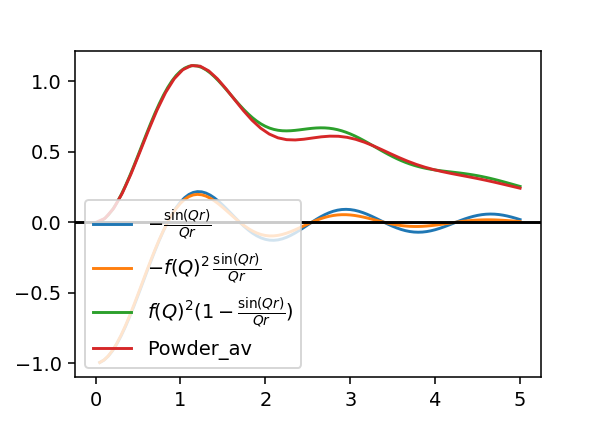

C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in divide
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: invalid value encountered in divide


In [11]:
import numpy as np
import os
import fnmatch
from scipy.signal import savgol_filter
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt # after importting matplotlib, mayavi can not set api to 2: first run mayavi!!!!
%matplotlib notebook

def tbformfact(q):# Tb3+ form factor
    s,j,l,ss = q/(4*np.pi), 6., 3., 3. ### Take care of the fraction 9/2=4
    fc = (j*(j+1)-ss*(ss+1)+l*(l+1))/(3*j*(j+1)+ss*(ss+1)-l*(l+1))
    
    j0 = [0.0177,25.5095,0.2921,10.5769,0.7133,3.5122,-0.0231]
    j2 = [0.2892,18.4973,1.1678,6.7972,0.9437,2.2573,0.0232]
    
    fm = (j0[0]*np.exp(-j0[1]*s**2) + j0[2]*np.exp(-j0[3]*s**2)+j0[4]*np.exp(-j0[5]*s**2) + j0[6] 
          + s**2*(j2[0]*np.exp(-j2[1]*s**2)+j2[2]*np.exp(-j2[3]*s**2)+j2[4]*np.exp(-j2[5]*s**2)+j2[6])*fc)
    return fm**2

# Ｐｏｗｄｅｒ　ａｖｅｒａｎｇｅｄ　ｓｔｒｕｃｔｕｒｅ　ｆａｃｔｏｒ　ｆｏｒ　ｐｙｒｏｃｈｌｏｒｅ　ＡＦＭ
from scipy import integrate

def pwAFMstrff(q,lattice): 
    def strff(th,phi):
        [h,k,l] = np.array([q*np.sin(th)*np.cos(phi), q*np.sin(th)*np.sin(phi), q*np.cos(th)])/(2*np.pi/lattice) 
        return 1. - 1.0/3*(np.cos(0.5*np.pi*h)*np.cos(0.5*np.pi*k)+
                           np.cos(0.5*np.pi*h)*np.cos(0.5*np.pi*l)+
                           np.cos(0.5*np.pi*k)*np.cos(0.5*np.pi*l))
    
    return integrate.nquad(strff, [[0, np.pi],[0, 2*np.pi]])[0] #/ (4*np.pi * q**2) 
            # No normalization because the area is multiplicity factor!!?? How about the Loritz factor?

vfunc = np.vectorize(pwAFMstrff,excluded=['lattice'])
qs = np.linspace(0.01,5.0,50)
sfs = tbformfact(qs) * vfunc(qs,10.4)

q = np.linspace(0,5,101,endpoint=True)
r=1*np.pi
r=3.7

plt.plot(q,-np.sin(q*r)/(q*r),label=r'$-\frac{\sin(Qr)}{Qr}$')
plt.plot(q,-np.sin(q*r)/(q*r)*tbformfact(q),label=r'$-f(Q)^2\,\frac{\sin(Qr)}{Qr}$')
plt.plot(q,(1-np.sin(q*r)/(q*r))*tbformfact(q),label=r'$f(Q)^2(1-\frac{\sin(Qr)}{Qr})$')
plt.plot(qs,sfs/20.,label='Powder_av')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.show()

In [2]:
################################### Read the dmc data ################
########### define the function to read ND DMC data file and the binning fun. #########
#################################################################
def read_dmc(fpath):
    with open(fpath, 'rU') as f:
        i, ii = 0, 0
        for line in f:     
            if i==0 or i==1:
                line = line.rstrip('\n').split()
                print "The data is",'\n',line
                i+=1
            elif i==2:          ##### Gernerate 2theta from inf. in the 3rd line
                line = line.rstrip('\n').split()
                spts,step,fpts = map(np.float,[line[0],line[1],line[2]])
                print spts,step,fpts
                numpts = int((fpts-spts)/step+1) # why 1314 is 1313 for np #### Ｈｅｒｅ　ｉｓ　ｄｉｆｆｅｒｅｎｔ　ｆｒｏｍ　ｔｈｅ　ｏｎｅ　ｆｏｒ　ＧｄＺｒＯ
                print 'The 2theta is',spts,step,fpts,numpts
                diffdata = np.zeros((numpts,3))
                print 'The data shape is',diffdata.shape
                diffdata[:,0] = np.linspace(spts,fpts,num=numpts,endpoint=True)
                i+=1
            else:              ##### Now read the intensity and error
                if ii<numpts-1:
                    line = line.rstrip('\n').split()
                    apd = len(line)
                    diffdata[ii:ii+apd,1]= map(np.float,line)
                    ii+=apd
                else:
                    if ii<2*numpts-1:
                        line = line.rstrip('\n').split()
                        apd = len(line)
                        diffdata[ii-numpts:ii-numpts+apd,2]= map(np.float,line)
                        ii+=apd
    return diffdata

#This binning with the error calculated in this way is not good if the input data has too few point. 
# For example, if nbins=size(x), error will be 0.
def lin_binning(x,y,nbins): #input: data x,y ; No of points you want nbins  
    #nbins+=1     
    x = x[~np.isnan(x)] # remove nan from the data
    y = y[~np.isnan(y)]
    
    n, _ = np.histogram(x, bins=nbins) # n=len(x)/nbins
    n[np.argwhere(n==0)]=1 #repalce 0 by 1 for dividing later
    meanx= np.histogram(x, bins=nbins, weights=x)[0] / n
    meany= np.histogram(x, bins=nbins, weights=y) [0]/ n
    meany2= np.histogram(x, bins=nbins, weights=y*y)[0] / n
    std_y = np.sqrt(meany2 - meany*meany)/np.sqrt(n)
    
    return np.column_stack((meanx,meany,std_y))#putput: nbins rows, 3 col

path='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\Raw data/'
data1=read_dmc(os.path.join(path,'THO_0p1K.dat'))

#print data1

The data is 
['DMC,', 'Tb2Hf2O7', '2.45A', 'BT']
The data is 
['lambda=', '2.45860,', 'T=', '0.121,', 'dT=', '0.019,', "Date='2015-07-21", "02:45:06'"]
3.0 0.1 92.7
The 2theta is 3.0 0.1 92.7 898
The data shape is (898L, 3L)


In [3]:
def rmcPlot(fpath, fname, whichFit, smooth, profix, vmin,vmax):
    '''Plot the data, fit, vkt and the spinCorrel
    fpath is the folder, fname is the name of the data file without '_data.txt';
    whichFit is a nb telling which fitted curve to plot;
    smooth is [int,int] for colormap smoothing;
    profix is the profix of the vtk files'''
    ##### Data and fit#####
    datname = os.path.join(fpath,fname)# data file name without '_dat.txt'
    data = np.genfromtxt(datname+'_data.txt')#data
    # Fitted curves
    fitname= fname+'_fit_*.txt'# fitted curves
    fnames=[] #index for different files
    for file in os.listdir(fpath):
        if fnmatch.fnmatch(file, fitname):      
            print(file)
            fnames.append(file)

    # Plot data and fit
    fig=plt.figure(figsize=(5,4))
    plt.errorbar(data[:,0],data[:,1],data[:,2], color='black', fmt='o',markersize='6', mfc='white', label='Data')
    for fname in [fnames[whichFit]]:
        fit = np.genfromtxt(os.path.join(fpath,fname), dtype=None, skip_header=1,delimiter=None)
        plt.plot(fit[:,0],fit[:,1],'red', label='Fitting',zorder=3)  
        #plt.plot(fit[:,0],data[1:,1]-fit[:,1],'red', label='Difference')
        
    plt.xlabel(r"$\rm Q\ (\AA$)",size=16)
    plt.ylabel('Intensity (a.u.)',size=16)
    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)
    plt.legend()
    plt.show()
    
    ##### Simulated single crystal [HHL] plane #####
    try:
        vtkpath = datname+'_sc'+profix+'.vtk' #_sc.vtk'
        print vtkpath
        x, y, intensity = loadvtk(vtkpath)        
        pltmap(x, y, intensity,smooth)#,vmin,vmax)
        plt.title(fname+'\n'+'unpolarized neutron')
    except:
        pass
    try:
        vtkpath = datname+'_sc_sf'+profix+'.vtk'#'_sc_sf.vtk'
        x, y, intensity = loadvtk(vtkpath)
        pltmap(x,y,intensity,smooth)#,vmin,vmax)
        plt.title(fname+'\n'+'SF polarized neutron')
    except:
        pass        
    try:
        vtkpath = datname+'_sc_snf'+profix+'.vtk'#'_sc_snf.vtk'
        x, y, intensity = loadvtk(vtkpath)
        pltmap(x,y,intensity,smooth)#,vmin,vmax)
        plt.title(fname+'\n'+'SNF polarized neutron')  
    except:
        pass
    
    #### Plot the spin correlation function #######
    fname= datname+'_scf.txt'# fitted curves
    scf = np.genfromtxt(fname, dtype=None, skip_header=0,delimiter=None)
#     fig = plt.figure(figsize=(5,4))   
#     plt.plot(scf[:,0],scf[:,1],color='black',linewidth=1)
#     plt.axhline(y=0)
#     plt.minorticks_on()
#     plt.xticks(color='k', size=14)
#     plt.yticks(color='k', size=14)    
#     plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
#     plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
#     plt.show()
    
    fig, ax = plt.subplots(figsize=(5,4))
    rects1 = ax.bar(scf[:,0],scf[:,1], width=1, color='r')
    plt.axhline(0, color='black', lw=2)
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)    
    plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
    plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
    plt.show()

    
    return

def loadvtk(vtkpath):
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(vtkpath)
    reader.ReadAllScalarsOn()
    reader.ReadAllVectorsOn()
    reader.Update()
    data = reader.GetOutput()
    dim = data.GetDimensions()
    
    d = data.GetPointData()
    array=d.GetArray('spin')
    intensity = vtk_to_numpy(array).reshape(dim[:-1],order='F')
    x = np.zeros(data.GetNumberOfPoints())
    y = np.zeros(data.GetNumberOfPoints())

    for i in range(data.GetNumberOfPoints()):
            x[i],y[i],_ = data.GetPoint(i) # coordinates x,y,z becuase z is the same, so discarded
    x = x.reshape(dim[:-1],order='F')# this type of reshape!!!
    y = y.reshape(dim[:-1],order='F')   
    return x, y, intensity

def pltmap(x,y,intensity,smooth):#,vmin,vmax):
    # Smooth the pattern by Apply gaussian filter
    #print intensity,smooth, vmin,vmax
    import scipy as sp
    import scipy.ndimage 
    sigma_y = smooth[0]
    sigma_x = smooth[1]
    sigma = [sigma_y, sigma_x]
    Z = sp.ndimage.filters.gaussian_filter(intensity, sigma, mode='constant')
    
    # only plot Instrument largest Q range
    Qlim = 4.5
    Qmod = np.sqrt(x**2+2*y**2) # why not the one: Qmod = np.sqrt(2*x**2+y**2)
    Zm = np.ma.masked_where(Qmod > Qlim, Z)

    fig = plt.figure(figsize=(5,4))
    #pcol = plt.pcolormesh(y, x, Zm, cmap='RdBu_r',vmin=vmin,vmax=vmax,linewidth=0,rasterized=True)# '_r' is reversed colormap
    pcol = plt.pcolormesh(y, x, Zm, cmap='RdBu_r',linewidth=0,rasterized=True)# '_r' is reversed colormap
    
    pcol.set_edgecolor('face') # remove the white lines in the plot
    #plt.title(fname)
    plt.axis([ -Qlim/1.414, Qlim/1.414,-Qlim, Qlim])
    plt.xlabel('[HH0]',size=14)
    plt.ylabel('[00L]',size=14)
    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)
    # set colorbar and its properties
    cb = plt.colorbar() # label='Intensity', ticks=range(0,100)
    cb.ax.set_ylabel('Intensity (a.u.)',fontsize=14)
    cb.ax.tick_params(labelsize=12)
    return

In [4]:
### DMC Read data: high temperature and low temperature
path='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\Raw data/'
data1=read_dmc(os.path.join(path,'THO_0p1K.dat'))
data2=read_dmc(os.path.join(path,'THO_160K.dat'))
#print data2

The data is 
['DMC,', 'Tb2Hf2O7', '2.45A', 'BT']
The data is 
['lambda=', '2.45860,', 'T=', '0.121,', 'dT=', '0.019,', "Date='2015-07-21", "02:45:06'"]
3.0 0.1 92.7
The 2theta is 3.0 0.1 92.7 898
The data shape is (898L, 3L)
The data is 
['DMC,', 'Tb2Hf2O7', '2.45A', 'cooling']
The data is 
['lambda=', '2.45860,', 'T=', '159.393,', 'dT=', '12.223,', "Date='2015-07-20", "12:47:01'"]
3.0 0.1 92.7
The 2theta is 3.0 0.1 92.7 898
The data shape is (898L, 3L)


<IPython.core.display.Javascript object>


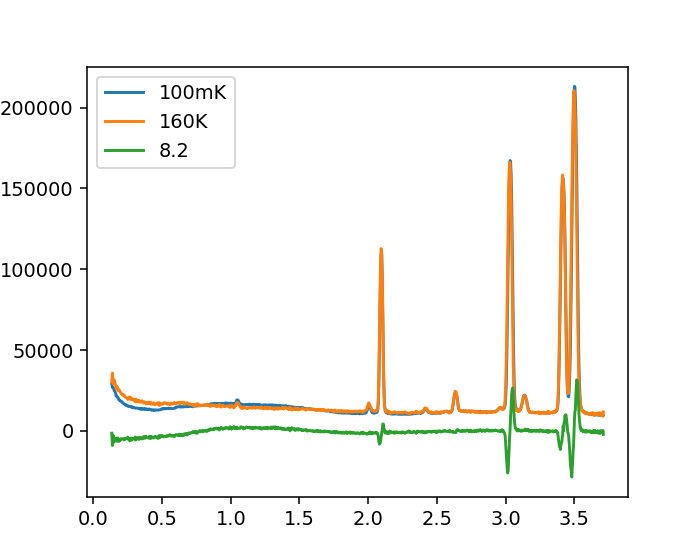

8.2


In [24]:
#DMC  Test differnt subtaction factor
%matplotlib notebook

#Convert the 2theta to Astrom
wavelen = 2.45
data1[:,0] = 4*np.pi* np.sin(data1[:,0]/2*np.pi/180.)/wavelen

fig = plt.figure(figsize=(5,4))
plt.plot(data1[:,0],data1[:,1],label='100mK')
plt.plot(data1[:,0],8.2*data2[:,1],label='160K')
for i in [8.2]:# np.arange(7.9,8.2,0.05):
    print i
    plt.plot(data1[:,0],data1[:,1]-i*data2[:,1],label=i)
#plt.axhline(y=0)
plt.legend().draggable()
plt.show()


<IPython.core.display.Javascript object>


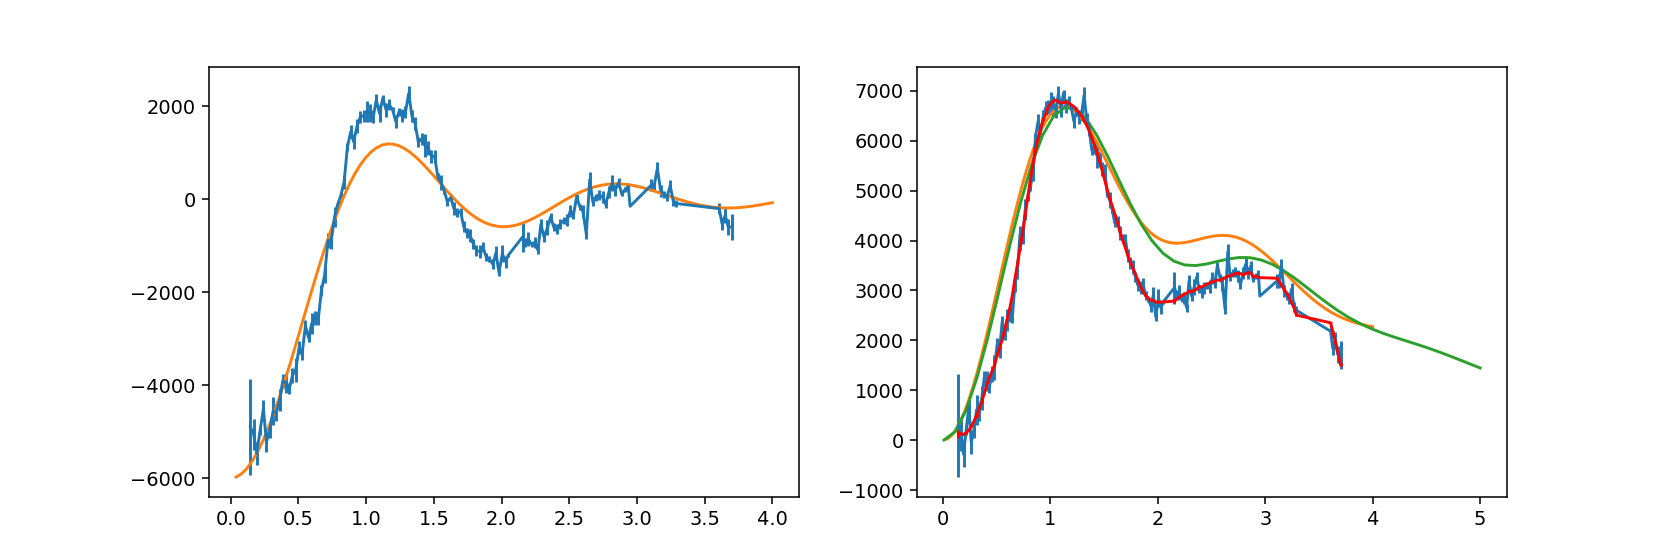

C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: invalid value encountered in divide
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: invalid value encountered in divide


In [61]:
#Ｓｕｂｔｒａｃｔｉｏｎ　ｒｅｍｏｖｅ　ｂａｄ　ｒａｎｇｅ　ａｎｄ　ｂｉｎｎｉｎｇ
#%matplotlib inline
path='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\Raw data/'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
#plt.plot(data1[:,0],data2[:,1]-data1[:,1],label=1)

# Subtraction
subed = data1[:,1]-8.2*data2[:,1] # at first it is 8.1
#plt.plot(data1[:,0],subed,label=0.97)

# Remove the data in this two ranges
selectd=np.where(~((2.05<data1[:,0])&(data1[:,0]<2.15) 
                   | ((2.95<data1[:,0])&(data1[:,0]<3.1))
                   | ((3.3<data1[:,0])&(data1[:,0]<3.6))))
#print selectd
newd = np.vstack((data1[selectd,0],subed[selectd],data1[selectd,2])).T
#plt.errorbar(newd[:,0],newd[:,1],newd[:,2])
#np.savetxt(os.path.join(path,'tho_100mk-160k.txt'),newd, fmt='%f')


# Binning
nbins = 150
binned = lin_binning(newd[:,0],newd[:,1],nbins)
#nongap = np.where(binned[:,0]!=0)# use this to select produce a deeper array
newdd = binned[binned[:,0]!=0,:]

# Add the paramagnetic part
scale_factor = 5200 # estimated for I(Q=0)=0
added = newdd[:,1] + scale_factor * tbformfact(newdd[:,0])

selectd=np.where(~((2.05<newdd[:,0])&(newdd[:,0]<2.15) 
                   | ((2.95<newdd[:,0])&(newdd[:,0]<3.1))
                   | ((3.3<newdd[:,0])&(newdd[:,0]<3.6))))
# print selectd
data = np.vstack((newdd[selectd,0],newdd[selectd,1],newdd[selectd,2])).T
axs[0].errorbar(data[:,0],data[:,1],data[:,2])
data = np.vstack((newdd[selectd,0],added[selectd],newdd[selectd,2])).T
axs[1].errorbar(data[:,0],data[:,1],data[:,2])

dat_smooth = savgol_filter(data[:,1], 21, 3) # window size 51, polynomial order 3
axs[1].errorbar(data[:,0],dat_smooth,0.1*data[:,2], color='red',label='Smoothed')

q = np.linspace(0,4,101,endpoint=True)
r=3.8
axs[0].plot(q,-6000*np.sin(q*r)/(q*r)*tbformfact(q),label=r'$f(Q)^2(1-\frac{\sin(Qr)}{Qr})$')
axs[1].plot(q,6000*(1-np.sin(q*r)/(q*r))*tbformfact(q),label=r'$f(Q)^2(1-\frac{\sin(Qr)}{Qr})$')
#axs[1].plot(qs,300*sfs,label=r'$Powder_av$') # after run the top cell

plt.show()

# Save data and smoothed
#data = np.column_stack()
#np.savetxt(os.path.join(path,'tho_100mk-160k_binned_8p2addP5250.txt'),data, fmt='%f')
#np.savetxt(os.path.join(path,'tho_100mk-160k_binned_8p2addP5200_smooth.txt'),np.vstack((data[:,0],dat_smooth,0.1*data[:,2])).T, fmt='%f')



In [32]:
#DMC  clc the scale factor for SpinVert
cons = 0.07265 #in barn
s = -1700 * -3/2 / cons
print s

35099.7935306


spinice_fit_01.txt
spinice_fit_02.txt
spinice_fit_03.txt
spinice_fit_04.txt
spinice_fit_05.txt
spinice_fit_06.txt
spinice_fit_07.txt
spinice_fit_08.txt
spinice_fit_09.txt
spinice_fit_10.txt
spinice_fit_11.txt
spinice_fit_12.txt


<IPython.core.display.Javascript object>


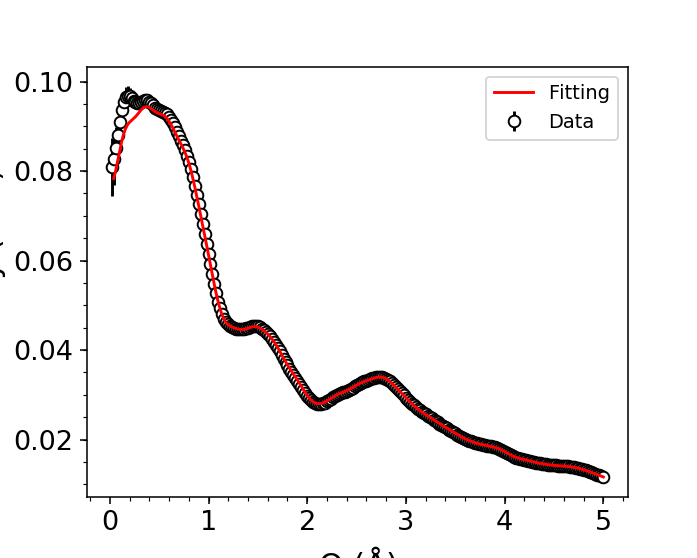

D:\9_Program files\SpinVert\0_spinvert_program\spinvert_with_modifed\examples\spinice/spinice_sc.vtk


<IPython.core.display.Javascript object>


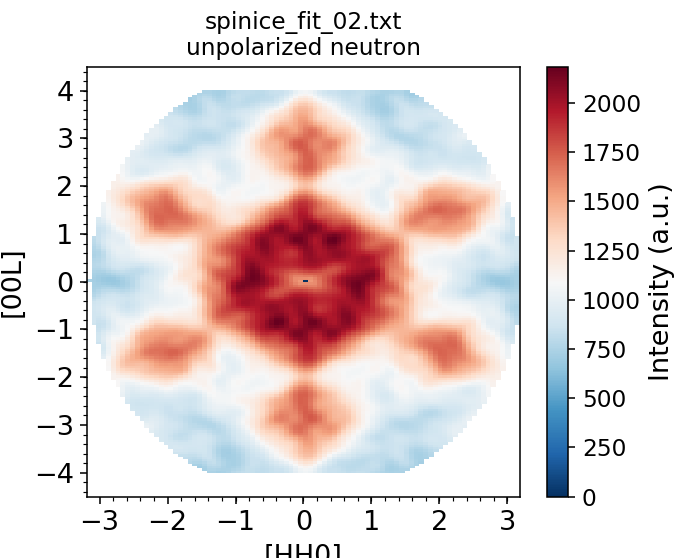

<IPython.core.display.Javascript object>


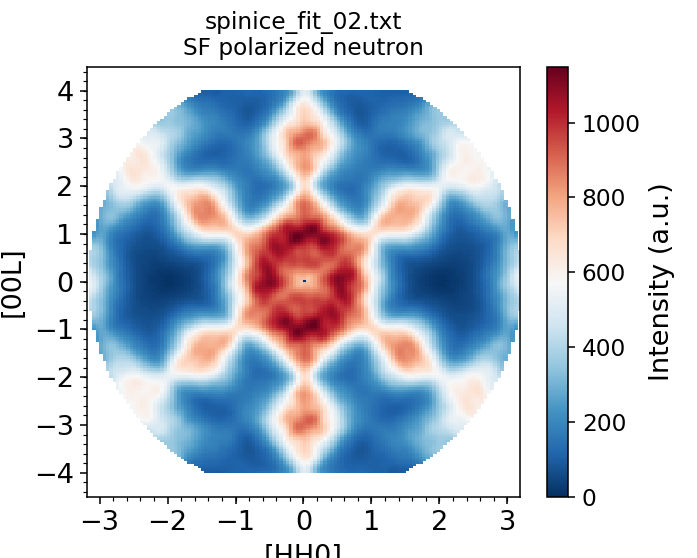

<IPython.core.display.Javascript object>


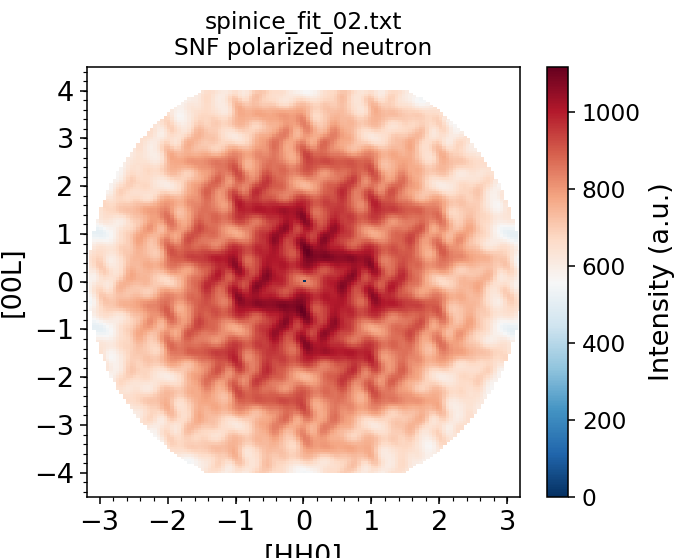

<IPython.core.display.Javascript object>


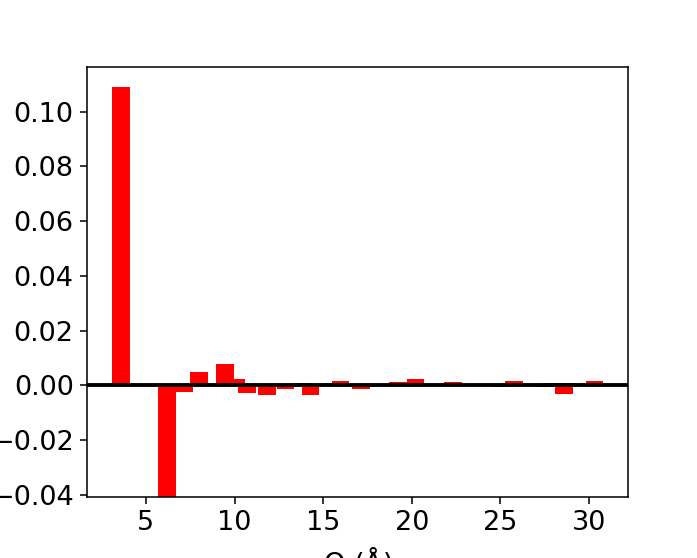

In [36]:
# Ｓｐｉｎｉｃｅ　ｔｅｓｔ　ｔｈｅ　ｆｕｎｃｔｉｏｎ spindiffxusfhhl and spindiffxusnfhhl for the polarized neutron sacattering 
fpath = r'D:\9_Program files\SpinVert\0_spinvert_program\spinvert_with_modifed\examples\spinice/'
fname = r'spinice'
whichFit = 1
smooth = [0,0]
profix = '';#profix of the vkt file name
rmcPlot(fpath,fname,whichFit,smooth,profix,vmin=0,vmax=1000)

tto_digital_fit_01.txt
tto_digital_fit_02.txt


<IPython.core.display.Javascript object>


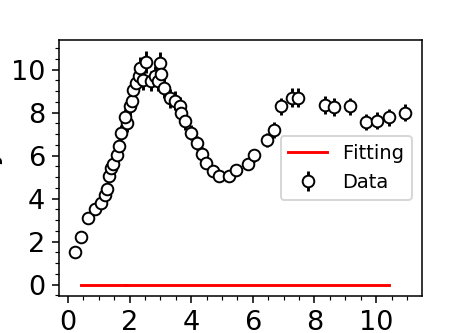

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tto_digitalized/tto_digital_sc.vtk


<IPython.core.display.Javascript object>


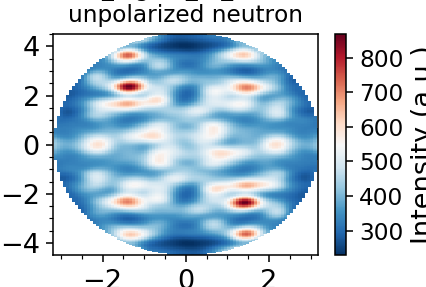

<IPython.core.display.Javascript object>


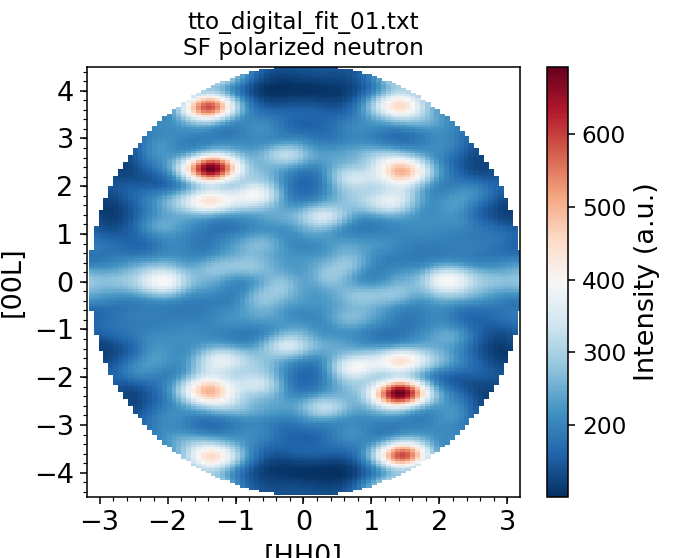

<IPython.core.display.Javascript object>


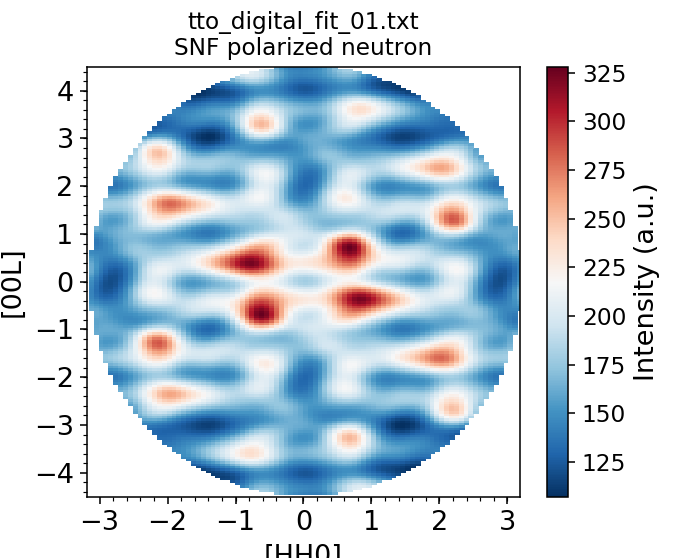

<IPython.core.display.Javascript object>


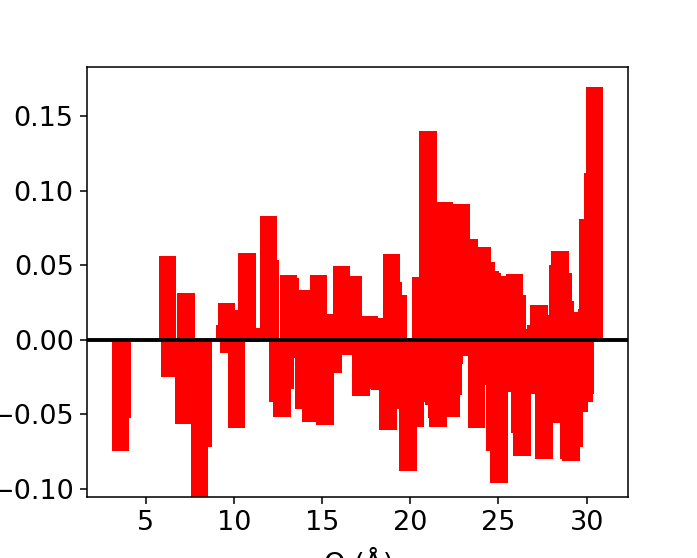

In [8]:
# Ｄｉｇｉｔａｌｉｚｅｄ　Ｔｂ２Ｔｉ２Ｏ７　ｄａｔａ　ｆｉｔｔｉｎｇ No fitted!!!!!!!!!!!!
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tto_digitalized/'
fname = r'tto_digital'
whichFit = 0
smooth = [3,3]
profix = '';#profix of the vkt file name
rmcPlot(fpath,fname,whichFit,smooth,profix,vmin=0,vmax=1000)

tho_digital_fit_01.txt
tho_digital_fit_02.txt
tho_digital_fit_03.txt


<IPython.core.display.Javascript object>


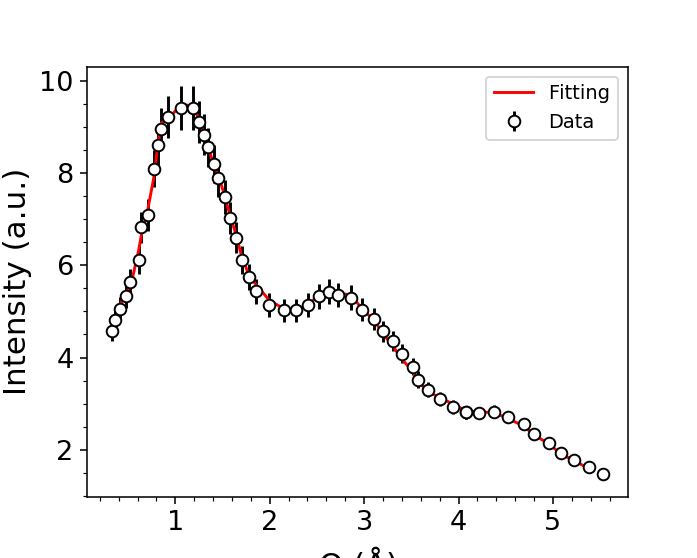

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_digitalized/tho_digital_sc.vtk


<IPython.core.display.Javascript object>


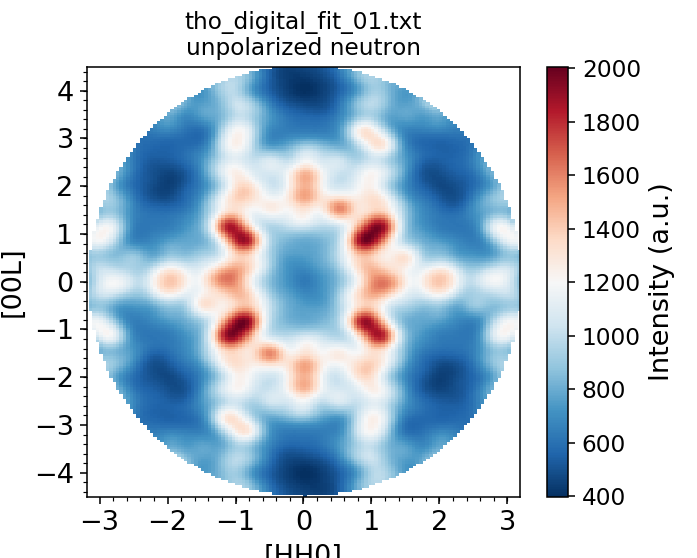

<IPython.core.display.Javascript object>


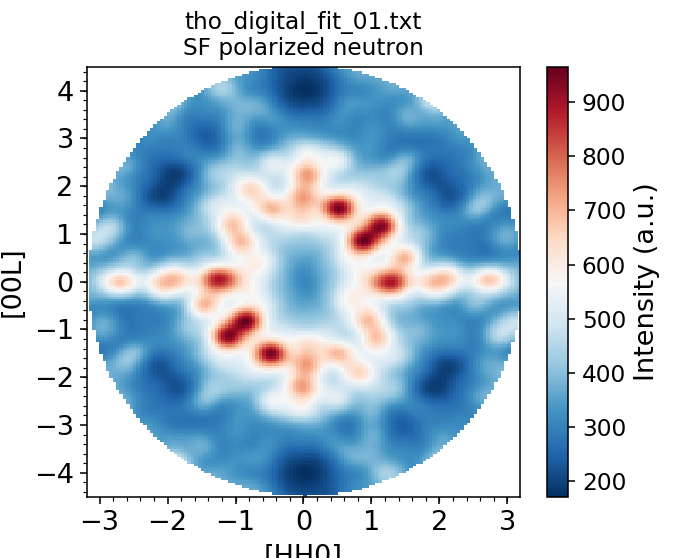

<IPython.core.display.Javascript object>


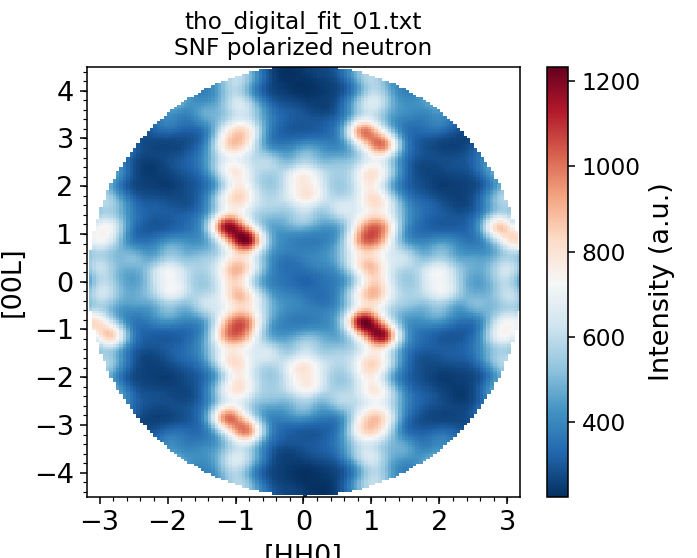

<IPython.core.display.Javascript object>


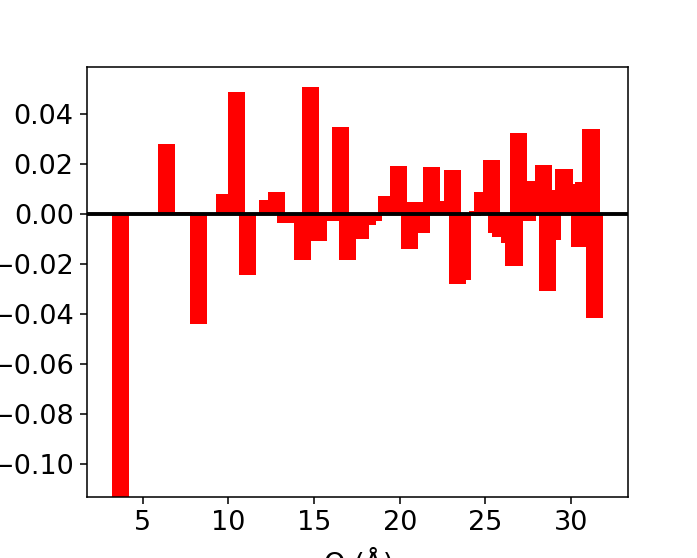

In [9]:
# Ｄｉｇｉｔａｌｉｚｅｄ　Ｔｂ２Hf２Ｏ７　ｄａｔａ　ｆｉｔｔｉｎｇ 
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_digitalized/'
#fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_digitalized\tho_digital_bkg/'
fname = r'tho_digital'
whichFit = 0
smooth = [3,3]
profix = '';#profix of the vkt file name
rmcPlot(fpath,fname,whichFit,smooth,profix,vmin=0,vmax=1000)

tho_100mk-160k_binned_addPara4900_fit_01.txt
tho_100mk-160k_binned_addPara4900_fit_02.txt
tho_100mk-160k_binned_addPara4900_fit_03.txt
tho_100mk-160k_binned_addPara4900_fit_04.txt
tho_100mk-160k_binned_addPara4900_fit_05.txt


<IPython.core.display.Javascript object>


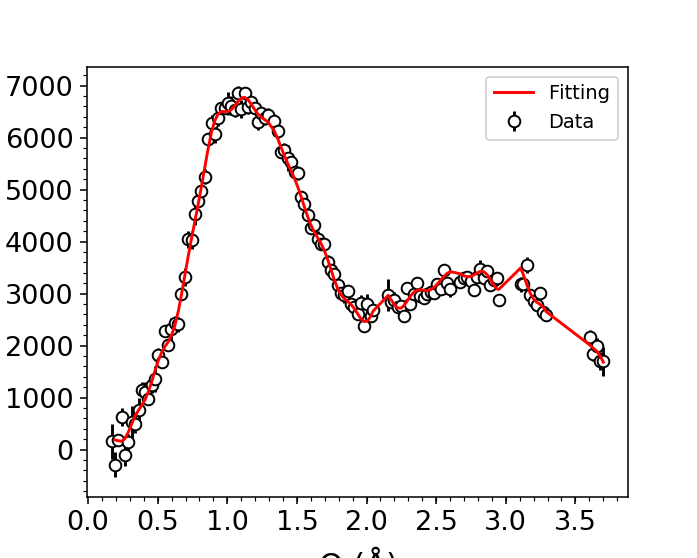

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/tho_100mk-160k_binned_addPara4900_sc.vtk


<IPython.core.display.Javascript object>


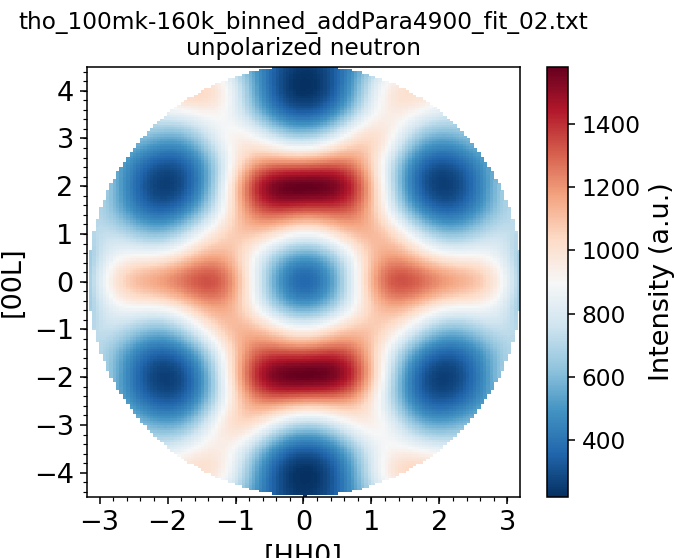

<IPython.core.display.Javascript object>


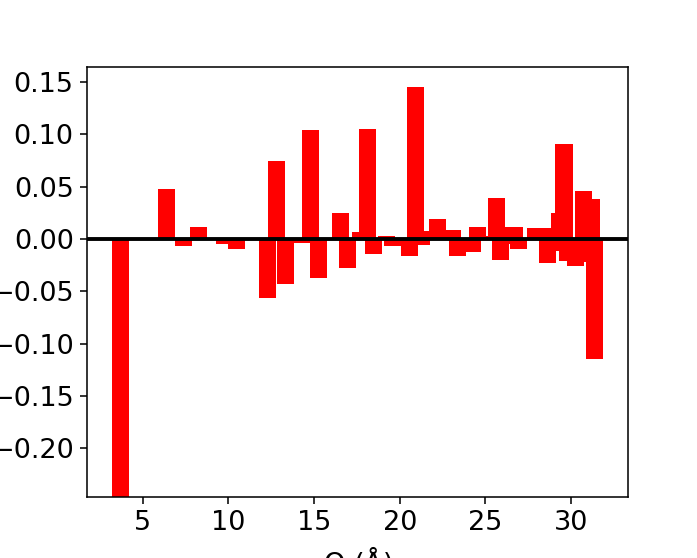

In [40]:
# Ｏｕｒ　ｄａｔａ　add paramagnetic 4900
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/'
fname = r'tho_100mk-160k_binned_addPara4900'
whichFit = 1
smoothVTK = [8,8]
profix = '' #profix of the vkt file name _111box, _222box, 333box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=1000)

tho_100mk-160k_binned_addPara4900_fit_01.txt
tho_100mk-160k_binned_addPara4900_fit_02.txt
tho_100mk-160k_binned_addPara4900_fit_03.txt
tho_100mk-160k_binned_addPara4900_fit_04.txt
tho_100mk-160k_binned_addPara4900_fit_05.txt


<IPython.core.display.Javascript object>


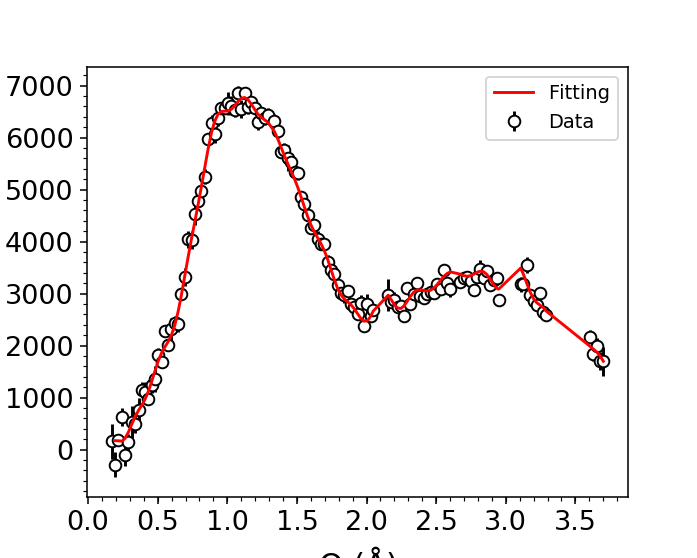

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara4900_easy_plane/tho_100mk-160k_binned_addPara4900_sc.vtk


<IPython.core.display.Javascript object>


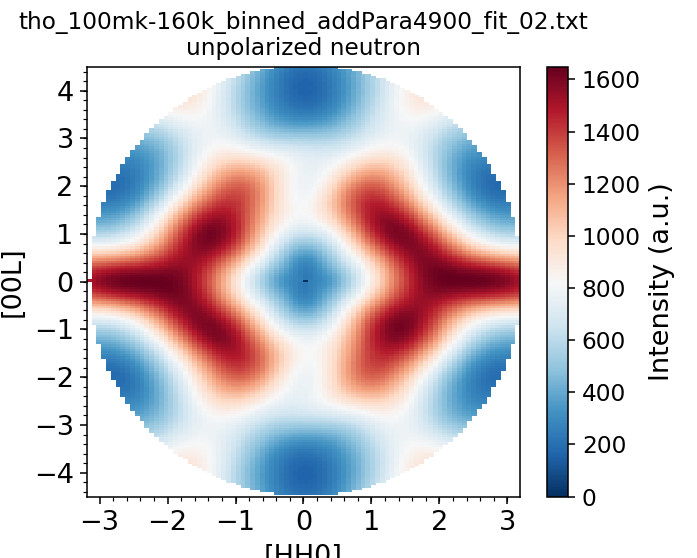

<IPython.core.display.Javascript object>


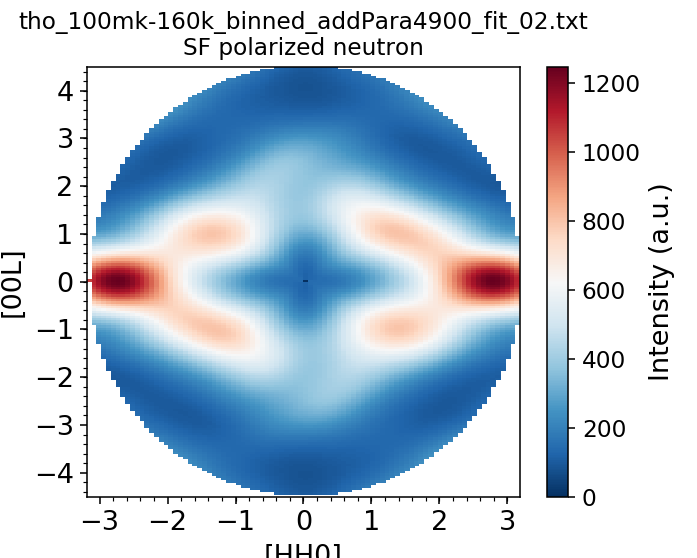

<IPython.core.display.Javascript object>


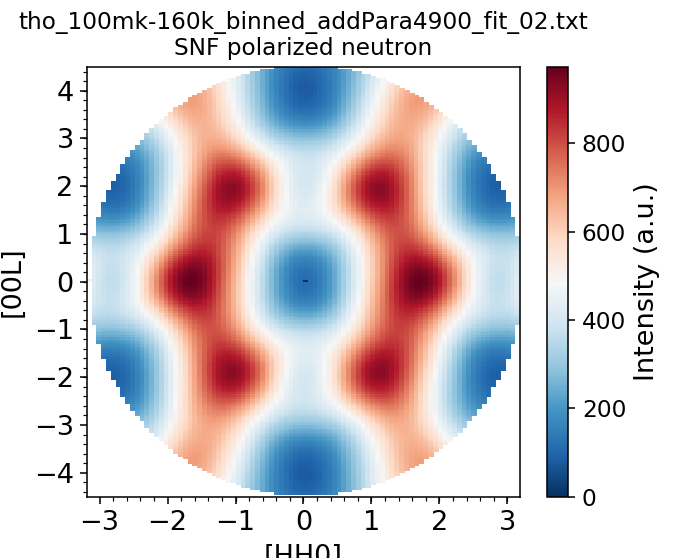

<IPython.core.display.Javascript object>


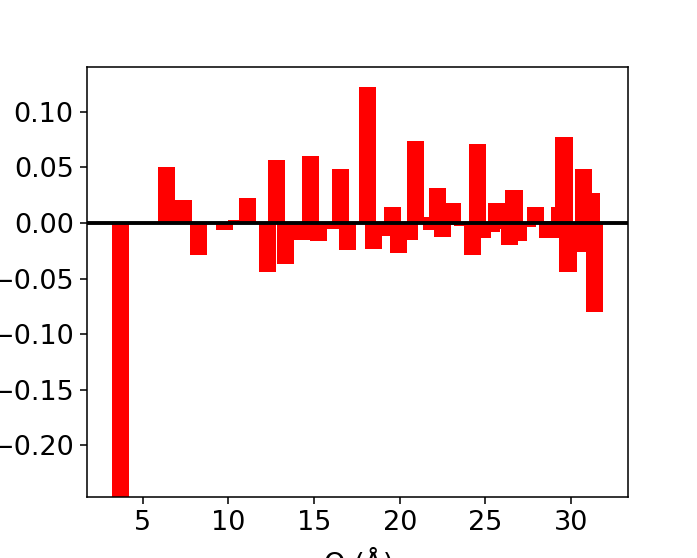

In [11]:
# data　add paramagnetic 4900, 
# fit with easy axis and easy plane
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara4900_easy_axis/'
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara4900_easy_plane/'
fname = r'tho_100mk-160k_binned_addPara4900'
whichFit = 1
smoothVTK = [0,0]
profix = '' #profix of the vkt file name _111box, _222box, 333box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=1000)

tho_100mk-160k_binned_addPara_fit_01.txt
tho_100mk-160k_binned_addPara_fit_02.txt
tho_100mk-160k_binned_addPara_fit_03.txt
tho_100mk-160k_binned_addPara_fit_04.txt
tho_100mk-160k_binned_addPara_fit_05.txt
tho_100mk-160k_binned_addPara_fit_06.txt
tho_100mk-160k_binned_addPara_fit_07.txt
tho_100mk-160k_binned_addPara_fit_08.txt
tho_100mk-160k_binned_addPara_fit_09.txt
tho_100mk-160k_binned_addPara_fit_10.txt


<IPython.core.display.Javascript object>


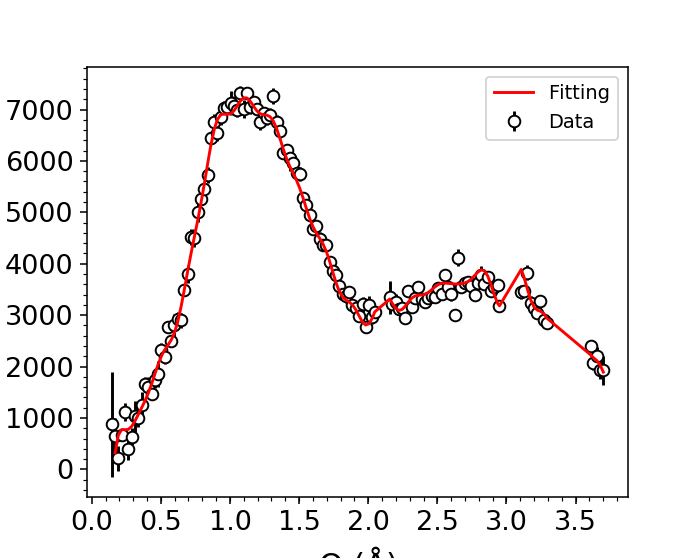

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/tho_100mk-160k_binned_addPara_sc_222box.vtk


<IPython.core.display.Javascript object>


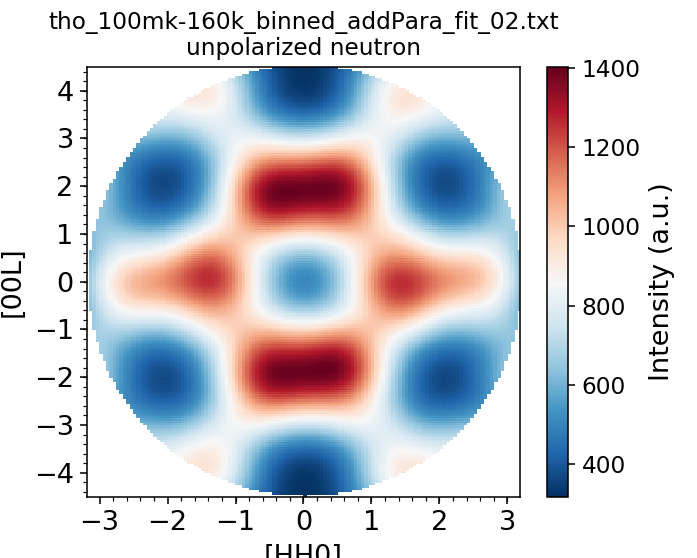

<IPython.core.display.Javascript object>


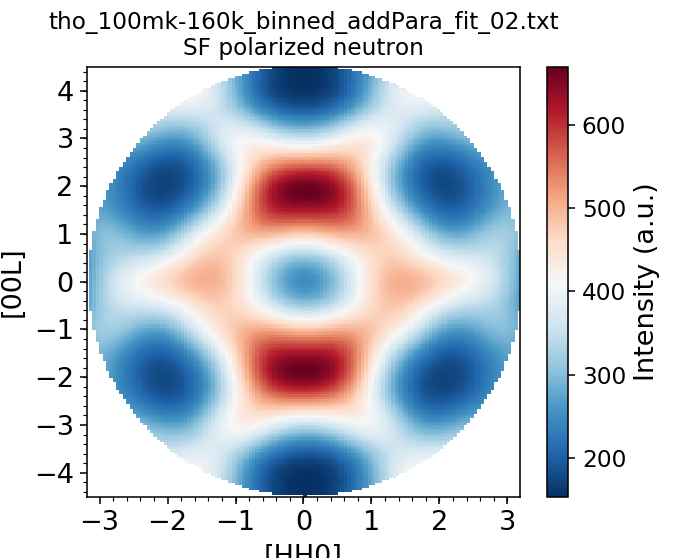

<IPython.core.display.Javascript object>


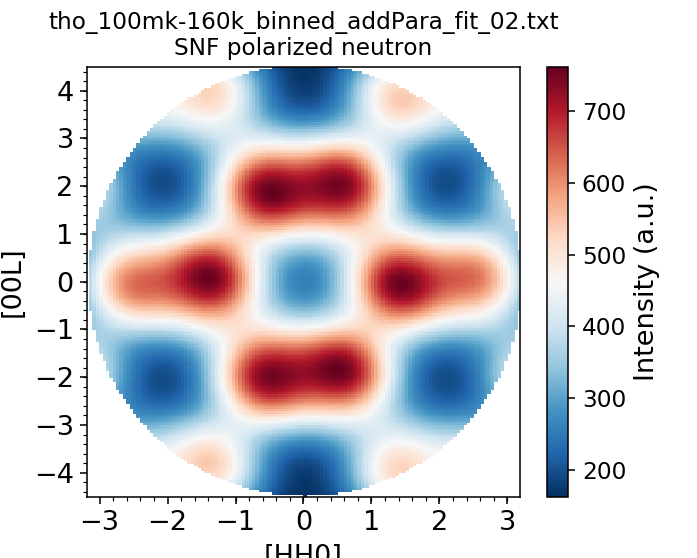

<IPython.core.display.Javascript object>


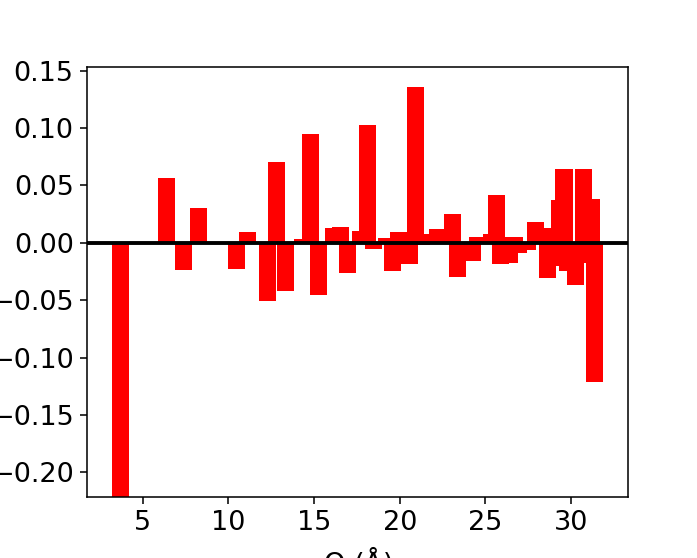

In [41]:
# data add paramagnetic 5400
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/'
fname = r'tho_100mk-160k_binned_addPara'
whichFit = 1
smoothVTK = [8,8]
profix = '_222box' #profix of the vkt file name _111box, _222box, 333box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=1000)

tho_100mk-160k_binned_8p2addP5300_fit_01.txt
tho_100mk-160k_binned_8p2addP5300_fit_02.txt
tho_100mk-160k_binned_8p2addP5300_fit_03.txt
tho_100mk-160k_binned_8p2addP5300_fit_04.txt
tho_100mk-160k_binned_8p2addP5300_fit_05.txt


<IPython.core.display.Javascript object>


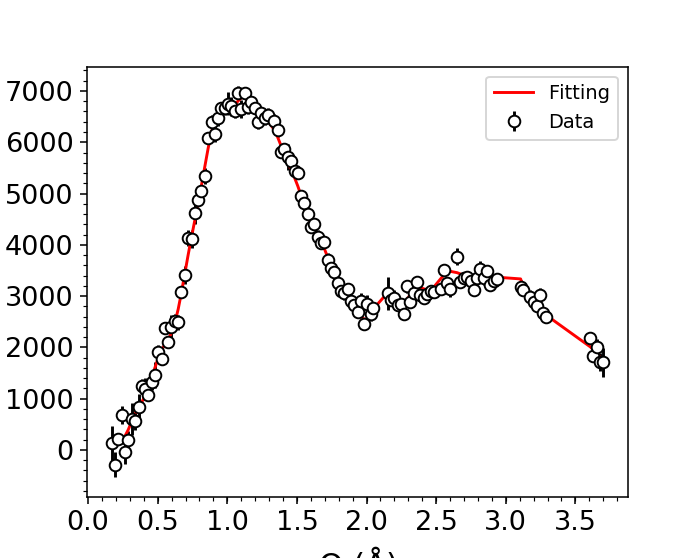

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5300_30%accept/tho_100mk-160k_binned_8p2addP5300_sc.vtk


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


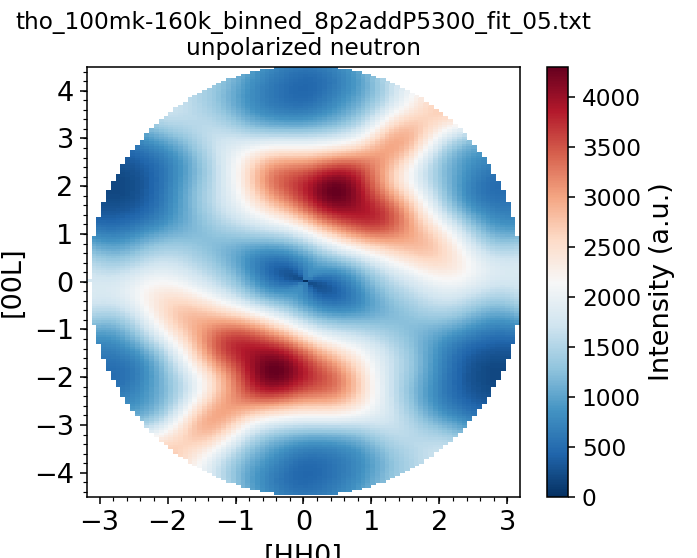

<IPython.core.display.Javascript object>


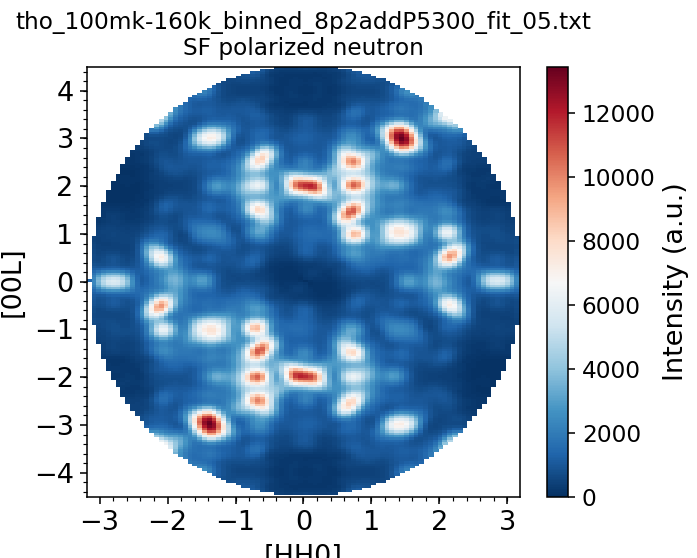

<IPython.core.display.Javascript object>


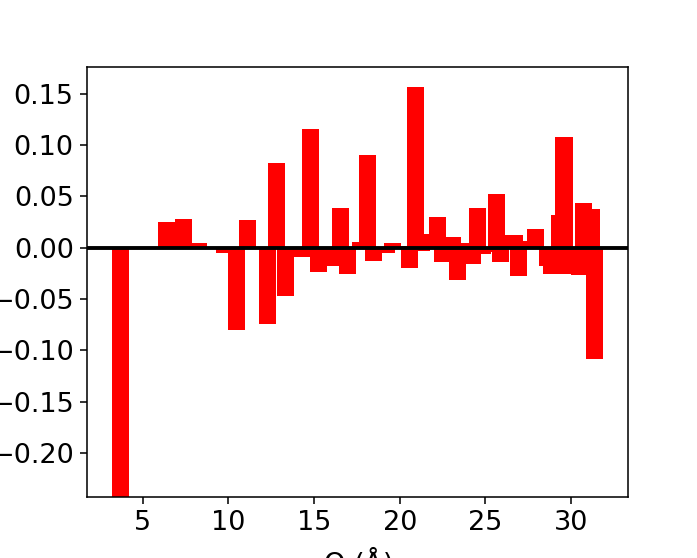

In [12]:
# data added paramagnetic 5300
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5300_30%accept/'
#fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5300_30%accept_bkg'
fname = r'tho_100mk-160k_binned_8p2addP5300'
whichFit = 4
smoothVTK = [0,0]
profix = ''
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

tho_100mk-160k_binned_8p2addP5300_fit_01.txt
tho_100mk-160k_binned_8p2addP5300_fit_02.txt
tho_100mk-160k_binned_8p2addP5300_fit_03.txt
tho_100mk-160k_binned_8p2addP5300_fit_04.txt
tho_100mk-160k_binned_8p2addP5300_fit_05.txt
tho_100mk-160k_binned_8p2addP5300_fit_06.txt
tho_100mk-160k_binned_8p2addP5300_fit_07.txt
tho_100mk-160k_binned_8p2addP5300_fit_08.txt
tho_100mk-160k_binned_8p2addP5300_fit_09.txt
tho_100mk-160k_binned_8p2addP5300_fit_10.txt


<IPython.core.display.Javascript object>


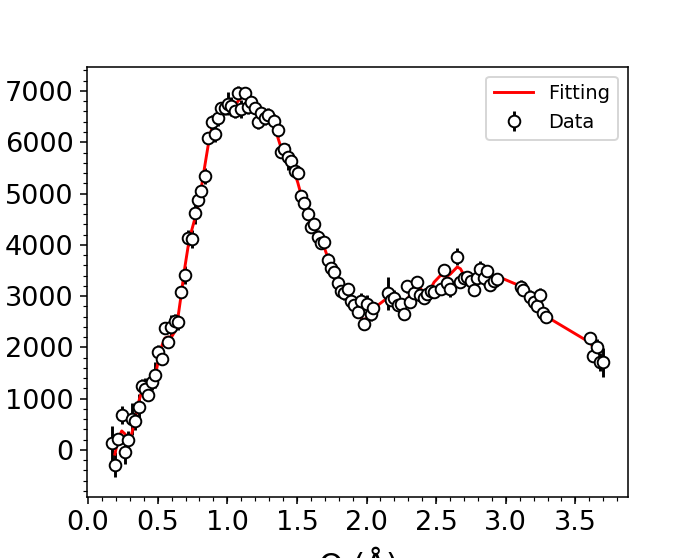

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\large_superCell\tho_100mk-160k_binned_8p2addP5300_30%accept-888cell\tho_100mk-160k_binned_8p2addP5300_sc.vtk


<IPython.core.display.Javascript object>


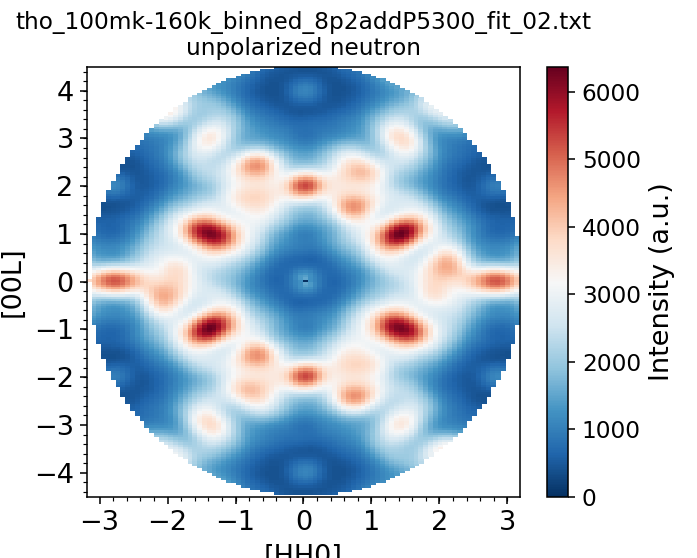

<IPython.core.display.Javascript object>


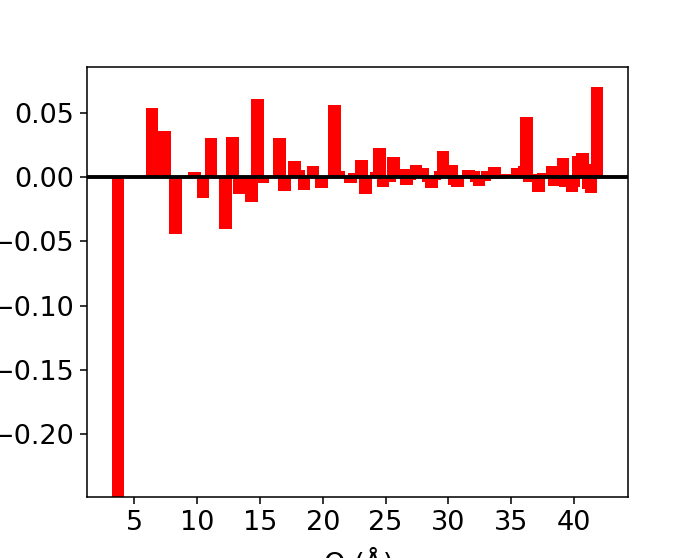

In [13]:
# 888 cell, no flat bkg
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\large_superCell\tho_100mk-160k_binned_8p2addP5300_30%accept-888cell'
fname = r'tho_100mk-160k_binned_8p2addP5300'
whichFit = 1
smoothVTK = [0,0] 
profix = '' #profix of the vkt file name
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=20)

tho_100mk-160k_binned_8p2addP5300_fit_01.txt
tho_100mk-160k_binned_8p2addP5300_fit_02.txt
tho_100mk-160k_binned_8p2addP5300_fit_03.txt


<IPython.core.display.Javascript object>


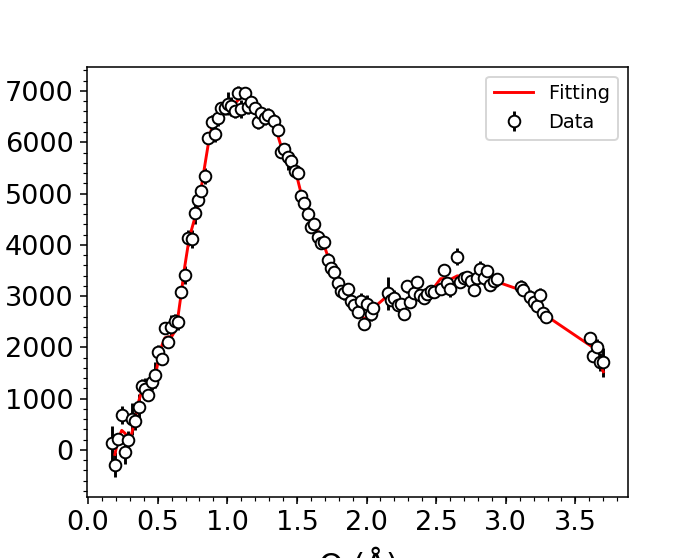

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\large_superCell\tho_100mk-160k_binned_8p2addP5300_bkg_888cell\tho_100mk-160k_binned_8p2addP5300_sc.vtk


<IPython.core.display.Javascript object>


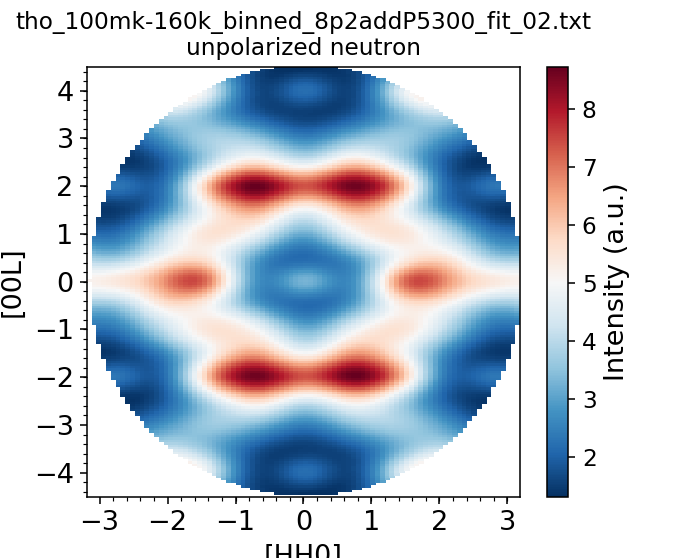

<IPython.core.display.Javascript object>


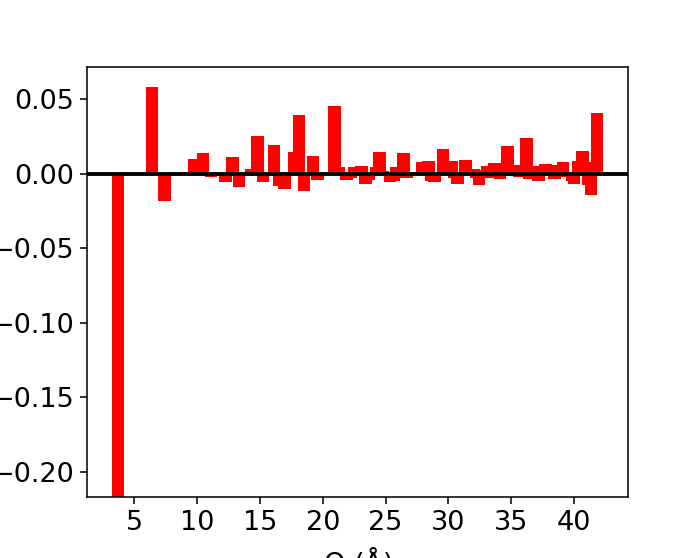

In [14]:
# 888 cell, flat bkg
fpath=r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\large_superCell\tho_100mk-160k_binned_8p2addP5300_bkg_888cell'
fname = r'tho_100mk-160k_binned_8p2addP5300'
whichFit = 1
smoothVTK = [5,5]
profix = '' #profix of the vkt file name
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=20)

In [7]:
# 222 supercell 30% acceptance with fitting a flat bkg
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\small_superCell\tho_100mk-160k_binned_8p2addP5300_30%accept_bkg-222cell'
fname = r'tho_100mk-160k_binned_8p2addP5300'
whichFit = 4
smoothVTK = [0,0]
rmcPlot(fpath,fname,whichFit,smoothVTK,0,100)

TypeError: rmcPlot() takes exactly 7 arguments (6 given)

In [8]:
# 444 supercell 30% acceptance with fitting a flat bkg
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\small_superCell\tho_100mk-160k_binned_8p2addP5300_30%accept_bkg'
fname = r'tho_100mk-160k_binned_8p2addP5300'
whichFit = 4
smoothVTK = [0,0]
rmcPlot(fpath,fname,whichFit,smoothVTK)

TypeError: rmcPlot() takes exactly 7 arguments (4 given)

tho_100mk-160k_binned_addPara4900_smooth_fit_01.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_02.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_03.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_04.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_05.txt


<IPython.core.display.Javascript object>


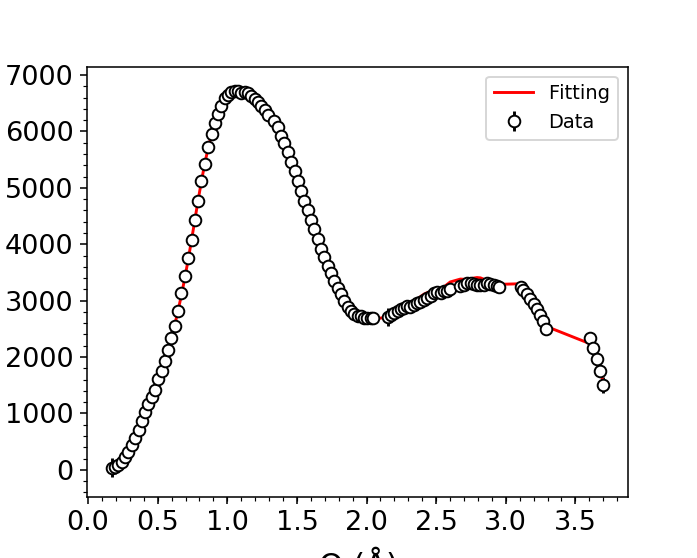

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara4900_smooth/tho_100mk-160k_binned_addPara4900_smooth_sc.vtk


<IPython.core.display.Javascript object>


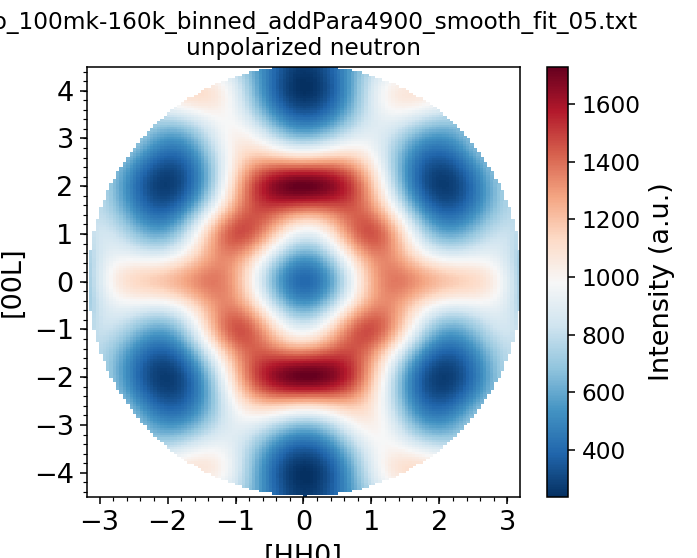

<IPython.core.display.Javascript object>


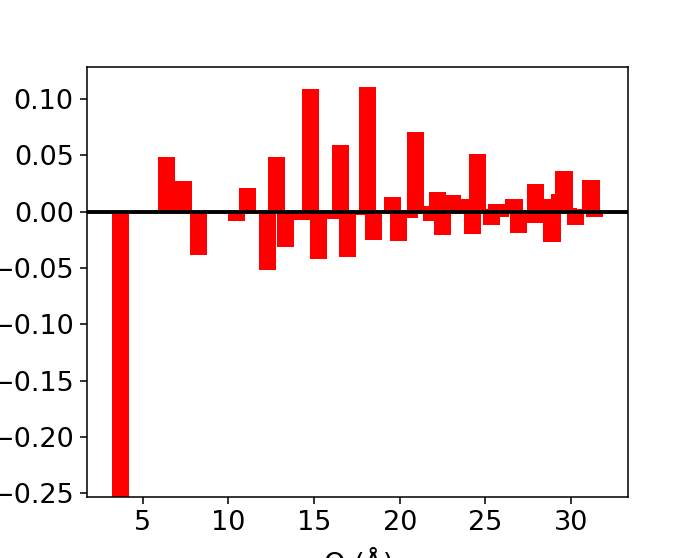

In [15]:
# fit the smoothed data
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara4900_smooth/'
fname = r'tho_100mk-160k_binned_addPara4900_smooth'
whichFit = 4
smoothVTK = [8,8]
profix = ''
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

tho_100mk-160k_binned_addPara4900_smooth_fit_01.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_02.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_03.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_04.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_05.txt


<IPython.core.display.Javascript object>


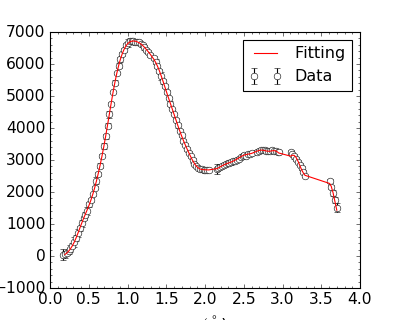

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara4900_smooth\flat_bkg/tho_100mk-160k_binned_addPara4900_smooth_sc.vtk


<IPython.core.display.Javascript object>


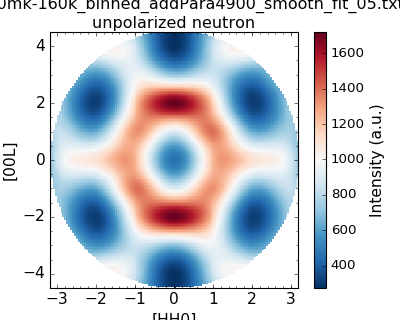

<IPython.core.display.Javascript object>


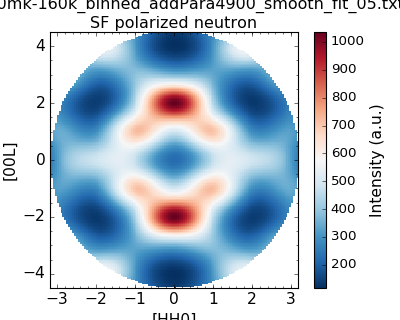

<IPython.core.display.Javascript object>


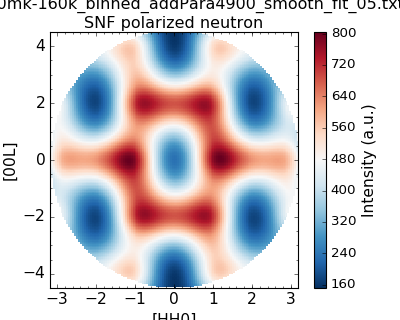

<IPython.core.display.Javascript object>


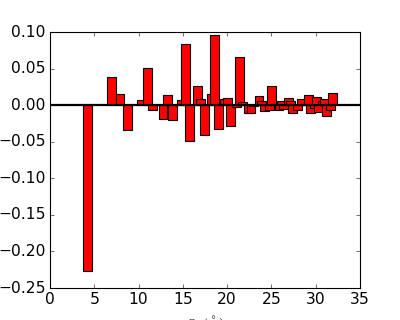

In [100]:
# fit the smoothed data fitted with a flat bkg
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara4900_smooth\flat_bkg/'
fname = r'tho_100mk-160k_binned_addPara4900_smooth'
whichFit = 4
smoothVTK = [8,8]
profix = ''
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

addP5250_fit_01.txt
addP5250_fit_02.txt
addP5250_fit_03.txt
addP5250_fit_04.txt


<IPython.core.display.Javascript object>


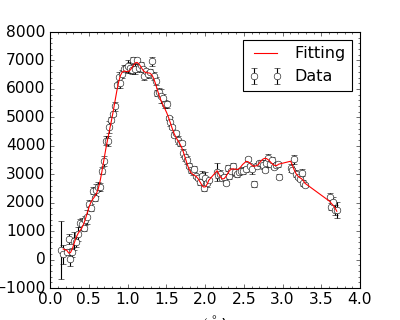

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5250/addP5250_sc.vtk


<IPython.core.display.Javascript object>


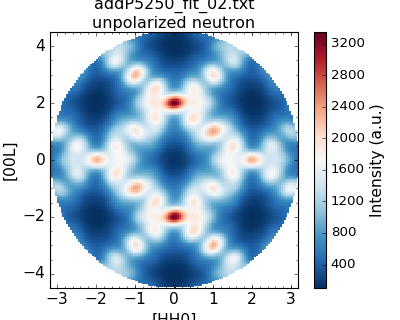

<IPython.core.display.Javascript object>


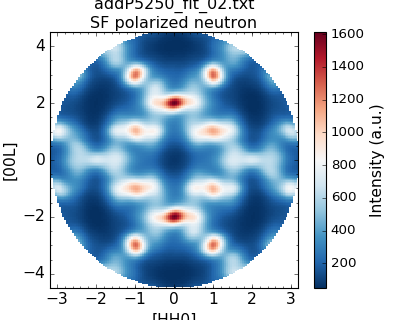

<IPython.core.display.Javascript object>


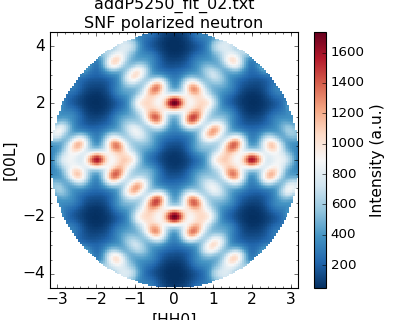

<IPython.core.display.Javascript object>


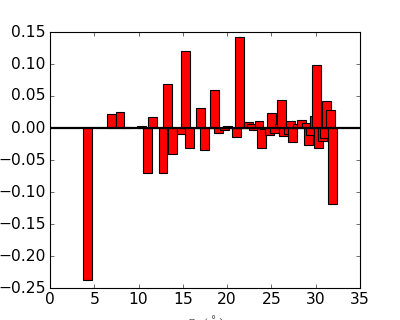

In [111]:
# Add paramag 5250
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5250/'
fname = r'addP5250'
whichFit = 1
smoothVTK = [3,3]
profix =''
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

tho_100mk-160k_binned_8p2addP5200_fit_01.txt
tho_100mk-160k_binned_8p2addP5200_fit_02.txt
tho_100mk-160k_binned_8p2addP5200_fit_03.txt
tho_100mk-160k_binned_8p2addP5200_fit_04.txt
tho_100mk-160k_binned_8p2addP5200_fit_05.txt


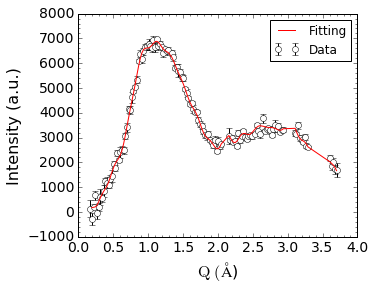

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5200/tho_100mk-160k_binned_8p2addP5200_sc_333box.vtk


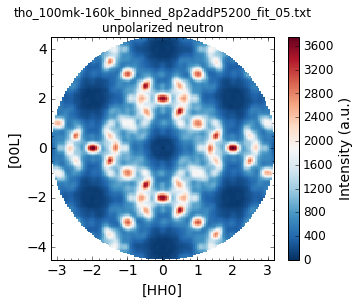

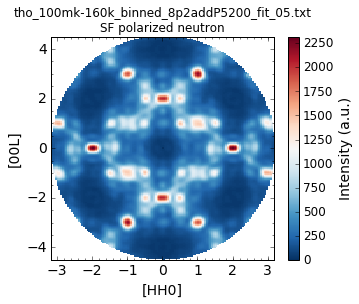

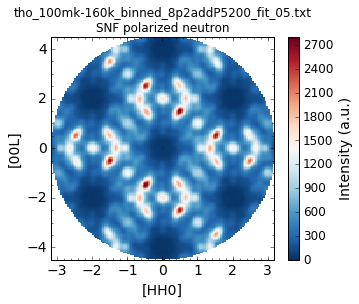

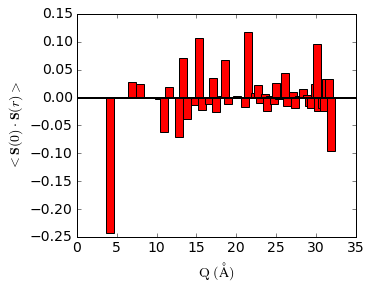

In [116]:
# Add paramag 5200
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5200/'
fname = r'tho_100mk-160k_binned_8p2addP5200'
whichFit = 4
smoothVTK = [0, 0]
profix = '_333box'
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

addP5200_smooth_fit_01.txt
addP5200_smooth_fit_02.txt
addP5200_smooth_fit_03.txt
addP5200_smooth_fit_04.txt
addP5200_smooth_fit_05.txt


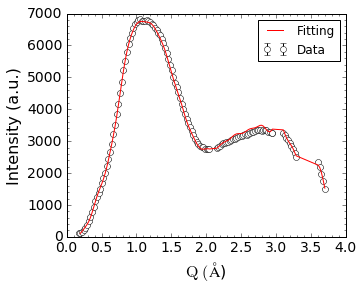

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5200_smooth/addP5200_smooth_sc.vtk


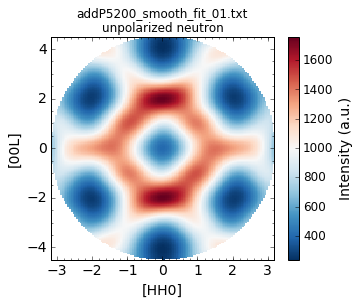

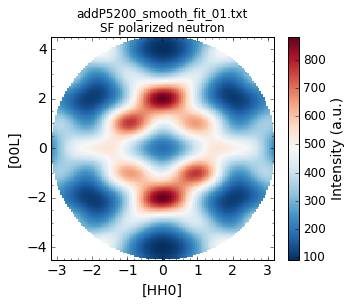

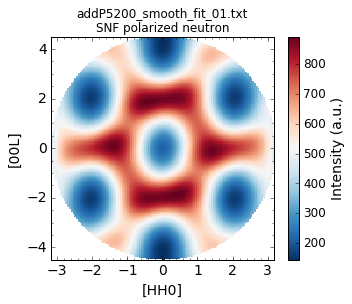

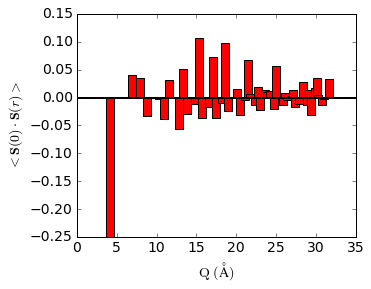

In [136]:
# Add paramag 5200 smoothed
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5200_smooth/'
fname = r'addP5200_smooth'
whichFit = 0
smoothVTK = [8, 8]
profix = ''# '_333box'
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

addP5100_fit_01.txt
addP5100_fit_02.txt
addP5100_fit_03.txt
addP5100_fit_04.txt
addP5100_fit_05.txt


<IPython.core.display.Javascript object>


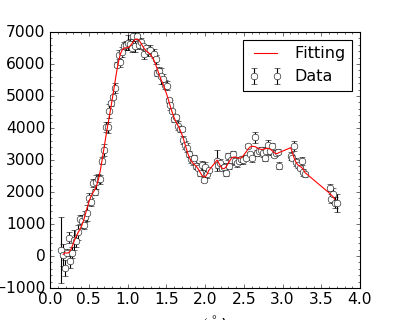

D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5100/addP5100_sc.vtk


<IPython.core.display.Javascript object>


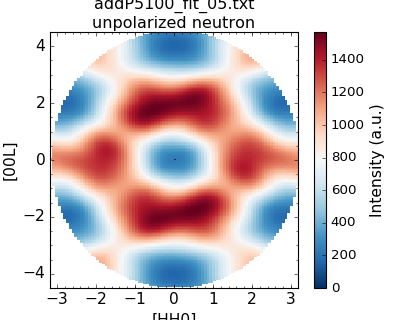

<IPython.core.display.Javascript object>


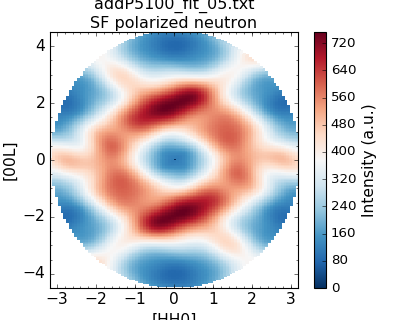

<IPython.core.display.Javascript object>


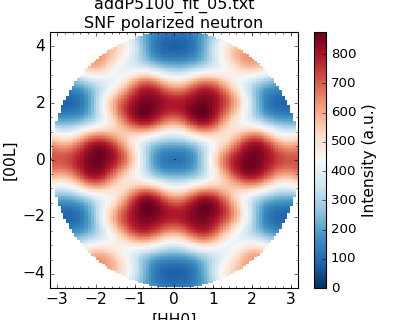

<IPython.core.display.Javascript object>


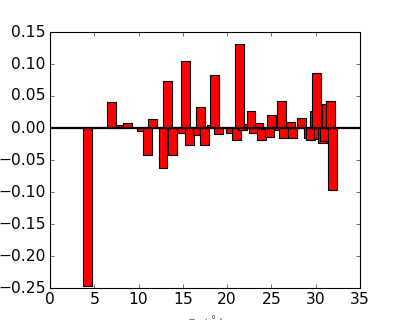

In [83]:
# Add paramag 5100
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5100/'
fname = r'addP5100'
whichFit = 4
smoothVTK = [0,0]
profix = ''# '_333box'
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

In [95]:
10.4*np.sqrt(2.)/4

3.6769552621700474

tho_100mk-160k_binned_addPara4900_fit_01.txt
tho_100mk-160k_binned_addPara4900_fit_02.txt
tho_100mk-160k_binned_addPara4900_fit_03.txt
tho_100mk-160k_binned_addPara4900_fit_04.txt
tho_100mk-160k_binned_addPara4900_fit_05.txt
['tho_100mk-160k_binned_addPara4900_fit_01.txt', 'tho_100mk-160k_binned_addPara4900_fit_02.txt', 'tho_100mk-160k_binned_addPara4900_fit_03.txt', 'tho_100mk-160k_binned_addPara4900_fit_04.txt', 'tho_100mk-160k_binned_addPara4900_fit_05.txt']


<IPython.core.display.Javascript object>


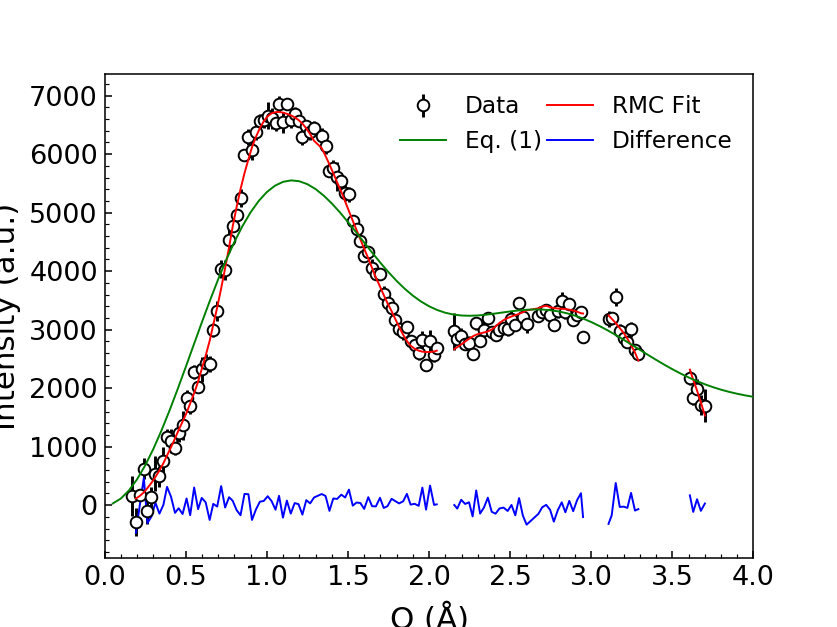

C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in divide


(0, 4)

In [56]:
#Ｐｌｏｔ　ｔｈｅ　ｄａｔａ　ａｎｄ　ｆｉｔｔｉｎｇ （binned data and with J2 in the form factor）
path='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/large_superCell/'
path='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/small_superCell/'
path='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/'
fname='tho_100mk-160k_binned_addPara4900_data.txt'

#path=r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5300_42%accept/'
#path=r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5300_30%accept/'
#fname = 'tho_100mk-160k_binned_8p2addP5300_data.txt'

# without paramagnetic intensity
# dataf = np.genfromtxt(os.path.join(path,'tho_100mk-160k_binned_data.txt'), dtype=None, skip_header=0,delimiter=None)
# fit = np.genfromtxt(os.path.join(path,'tho_100mk-160k_binned_fit_01.txt'), dtype=None, skip_header=1,delimiter=None)

# with paramagnetic intensity
dataf = np.genfromtxt(os.path.join(path,fname), dtype=None, skip_header=0,delimiter=None)
fname='tho_100mk-160k_binned_addPara4900_fit_*.txt'
#fname = 'tho_100mk-160k_binned_8p2addP5300_fit_*.txt'
fnames=[] #index for different files
for file in os.listdir(path):
    if fnmatch.fnmatch(file, fname):      
        print(file)
        fnames.append(file)
print fnames

# Plot
fig=plt.figure(figsize=(6,4.5))
plt.errorbar(dataf[:,0],dataf[:,1],dataf[:,2], color='black', fmt='o',markersize='6', mfc='white', label='Data')

# Fit the powder-averaged scattering of isotropic spins
# from scipy.optimize import curve_fit
# popt, pcov = curve_fit(lambda q, amp, r: (1-amp*np.sin(q*r)/(q*r))*tbformfact(q),
#                        dataf[:,0],dataf[:,1], p0=[5000,3.7], sigma=dataf[:,2], absolute_sigma=False)
# print 'amp', 'r', popt
# q = np.linspace(0,3.8,101,endpoint=True)
# plt.plot(q,popt[0]*(1-np.sin(q*popt[1])/(q*popt[1]))*tbformfact(q),color='green',lw=1.,label=r'$f(Q)^2(1-\frac{\sin(Qr)}{Qr})$')

r=3.7
plt.plot(q,5000*(1-np.sin(q*r)/(q*r))*tbformfact(q),zorder=4,color='green',lw=1.,label='Eq. (1)')
         #label=r'$f(Q)^2[1-\frac{\sin(Qr_\mathrm{nn})}{Qr_\mathrm{nn}}]$')

plt.xlabel(r"$\rm Q\ (\AA$)",size=16)
plt.ylabel('Intensity (a.u.)',size=16)


############### smooth the data and save for fitting with 0.5*error
####################################################################
#dat_smooth = savgol_filter(dataf[:,1], 21, 3) # window size 51, polynomial order 3
#plt.plot(dataf[:,0],dat_smooth, color='red',label='Smoothed')
#np.savetxt(os.path.join(path,'tho_100mk-160k_binned_addPara4900_smooth.txt'),np.vstack((dataf[:,0],dat_smooth,0.5*dataf[:,2])).T, fmt='%f')

for fname in [fnames[0]]:
    fit = np.genfromtxt(os.path.join(path,fname), dtype=None, skip_header=1,delimiter=None)
    
    fit_smooth = savgol_filter(fit[:,1], 21, 3) # window size 51, polynomial order 3
    diff = dataf[1:,1]-fit[:,1]
    
    #plt.plot(fit[:,0],fit[:,1],'red', label='Fitting',zorder = 3) 
    m0, m1, m2, m3 = fit[:,0]<2.07, (2.125<fit[:,0])&(fit[:,0]<3.), (3.<fit[:,0])&(fit[:,0]<3.5), 3.5<fit[:,0]
    
    plt.plot(fit[m0,0],fit_smooth[m0],fit[m1,0],fit_smooth[m1],fit[m2,0],fit_smooth[m2],fit[m3,0],fit_smooth[m3],
             color='red',linewidth=1, label='RMC Fit',zorder = 3)
    plt.plot(fit[m0,0],diff[m0],fit[m1,0],diff[m1],fit[m2,0],diff[m2],fit[m3,0],diff[m3],
             color = 'blue', linewidth=1,label='Difference')


# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend([handles[8],handles[0],handles[4]], [labels[8],labels[0],labels[4]],
#            loc='best',numpoints=1,frameon=False,framealpha=1,fontsize=14,fancybox=True,shadow=False)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[9],handles[0],handles[4],handles[8]], [labels[9],labels[0],labels[4],labels[8]],ncol=2,columnspacing=0.2,
           loc='best',numpoints=1,frameon=False,framealpha=1,fontsize=12,fancybox=True,shadow=False).draggable()

plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)
plt.tick_params(axis='both',which='both',direction='in')
plt.xlim([0,4])
#plt.legend(frameon=False)
#plt.show()
# plt.title('New: The un-shifted data and fit')
#fig.savefig('D:/9_Program files/SpinVert/gdzro_ill/fullprof/scale_7p2k_longRun.pdf', bbox_inches="tight",verbose=True) 

#fig.savefig(os.path.join(path,fname).replace('txt','eps'), bbox_inches="tight",verbose=True) 


tho_100mk-160k_binned_addPara4900_smooth_fit_01.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_02.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_03.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_04.txt
tho_100mk-160k_binned_addPara4900_smooth_fit_05.txt
['tho_100mk-160k_binned_addPara4900_smooth_fit_01.txt', 'tho_100mk-160k_binned_addPara4900_smooth_fit_02.txt', 'tho_100mk-160k_binned_addPara4900_smooth_fit_03.txt', 'tho_100mk-160k_binned_addPara4900_smooth_fit_04.txt', 'tho_100mk-160k_binned_addPara4900_smooth_fit_05.txt']


<IPython.core.display.Javascript object>


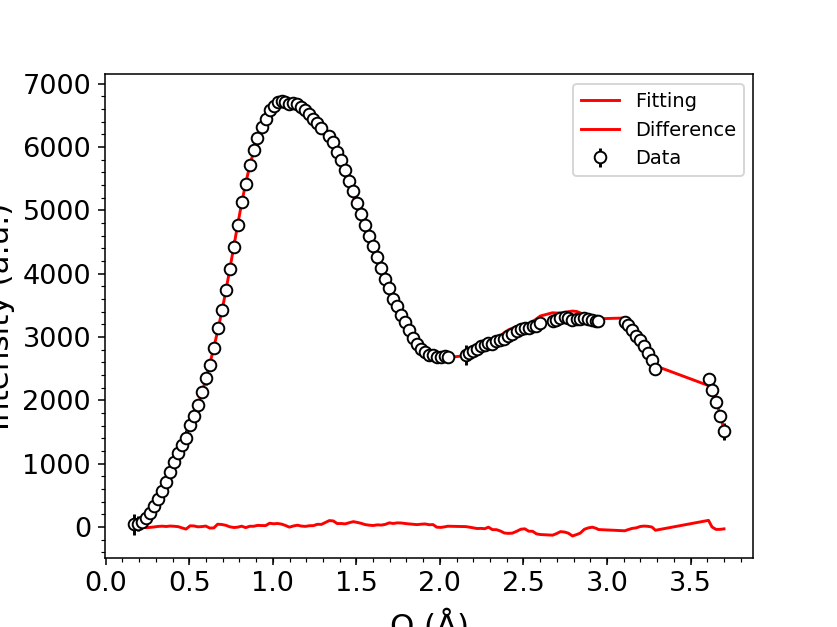

In [8]:
#Ｐｌｏｔ　ｔｈｅ　ｄａｔａ　ａｎｄ　ｆｉｔｔｉｎｇ (binned, smoothed and with J2)
fpath=r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara4900_smooth/'
fname = r'tho_100mk-160k_binned_addPara4900_smooth_data.txt'

dataf = np.genfromtxt(os.path.join(fpath,fname))# smoothed data

fname='tho_100mk-160k_binned_addPara4900_smooth_fit_*.txt' # fitted curves
fnames=[] #index for different files
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fname):      
        print(file)
        fnames.append(file)
print fnames

# Plot
fig=plt.figure(figsize=(6,4.5))
plt.errorbar(dataf[:,0],dataf[:,1],dataf[:,2], color='black', fmt='o',markersize='6', mfc='white', label='Data')

for fname in [fnames[4]]:
    fit = np.genfromtxt(os.path.join(fpath,fname), dtype=None, skip_header=1,delimiter=None)
    plt.plot(fit[:,0],fit[:,1],'red', label='Fitting')  
    plt.plot(fit[:,0],dataf[1:,1]-fit[:,1],'red', label='Difference')

plt.xlabel(r"$\rm Q\ (\AA$)",size=16)
plt.ylabel('Intensity (a.u.)',size=16)
#handles, labels = plt.gca().get_legend_handles_labels()
#plt.legend([handles[1],handles[0]], [labels[1],labels[0]],loc='best',numpoints=1,frameon=False,framealpha=1,fontsize=14,fancybox=True,shadow=False)

plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


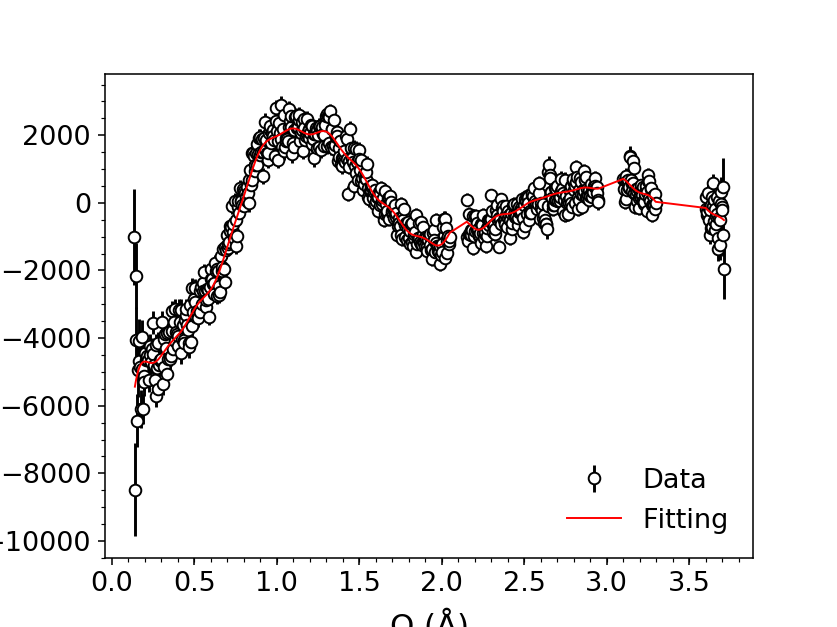

In [6]:
#Ｐｌｏｔ　ｔｈｅ　ｄａｔａ　ａｎｄ　ｆｉｔｔｉｎｇ (unbinned and with J2)

#%　matplotlib inline
path='D:\9_Program files\SpinVert\TbHfO_ND_Vivek/'

dataf = np.genfromtxt(os.path.join(path,'tho_100mk-160k_data.txt'), dtype=None, skip_header=0,delimiter=None)
fit = np.genfromtxt(os.path.join(path,'tho_100mk-160k_fit_01.txt'), dtype=None, skip_header=1,delimiter=None)

fig=plt.figure(figsize=(6,4.5))
# plt.plot(dataf[:,0],dataf[:,1],color='black',linewidth=1)
plt.errorbar(dataf[:,0],dataf[:,1],dataf[:,2], color='black', fmt='o',markersize='6', mfc='white', label='Data')
#plt.plot(data1[:,0],data1[:,1],color='red',linewidth=1)
plt.plot(fit[:,0],fit[:,1],color='red',linewidth=1, label='Fitting',zorder=3)

plt.xlabel(r"$\rm Q\ (\AA$)",size=16)
plt.ylabel('Intensity (a.u.)',size=16)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[1],handles[0]], [labels[1],labels[0]],loc='best',numpoints=1,frameon=False,framealpha=1,fontsize=14,fancybox=True,shadow=False)

plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)
plt.show()
# plt.title('New: The un-shifted data and fit')
#fig.savefig('D:/9_Program files/SpinVert/gdzro_ill/fullprof/scale_7p2k_longRun.pdf', bbox_inches="tight",verbose=True)  

In [210]:
print 3000./365
647/12.
print (0.2572*2500+119-212)/12

8.21917808219
45.8333333333


(201, 161)
5.0


<IPython.core.display.Javascript object>


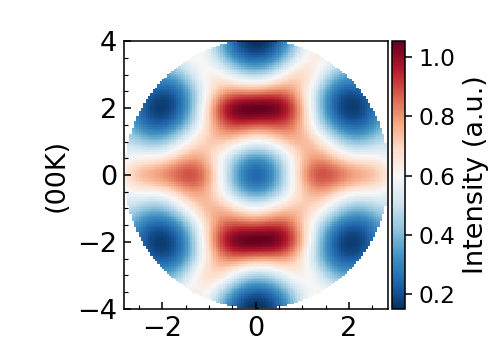

In [5]:
# ＰＬｏｔ　ｔｈｅ　ｓｉｍｕｌａｔｅｄ　ｓｉｎｇｌｅ　ｃｒｙｓｔａｌ　ｄｉｆｆｕｓｅ　ｓｃａｔｔｅｒｉｎｇ　ｐａｔｔｅｒｎ
# Smooth: http://stackoverflow.com/questions/33548639/how-can-i-smooth-elements-of-a-two-dimensional-array-with-differing-gaussian-fun
# [HHK] plane
# load vtk and plot with Matplotlib

% matplotlib notebook

#fpath='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/tho_100mk-160k_binned_sc.vtk'
#fpath='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/tho_100mk-160k_binned_addPara_sc_hhl.vtk'
#fpath='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/tho_100mk-160k_binned_addPara_sc.vtk'
fpath='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/tho_100mk-160k_binned_addPara4900_sc.vtk'
#fpath='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/large_superCell/tho_100mk-160k_binned_addPara4900_sc_server.vtk'
#fpath='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/small_superCell/tho_100mk-160k_binned_addPara4900_sc.vtk'

# The smooth data fitting
#fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5300_30%accept/'
#fname = r'tho_100mk-160k_binned_8p2addP5300_sc.vtk'
#fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara4900_smooth\flat_bkg/'
#fname = r'tho_100mk-160k_binned_addPara4900_s_sc.vtk'


#fpath = os.path.join(fpath,fname) 

reader = vtk.vtkDataSetReader()
reader.SetFileName(fpath)
reader.ReadAllScalarsOn()
reader.ReadAllVectorsOn()
reader.Update()

data = reader.GetOutput()
dim = data.GetDimensions()
print dim[:-1]

d = data.GetPointData()
array=d.GetArray('spin')
intensity = vtk_to_numpy(array).reshape(dim[:-1],order='F')
#array = reader.GetOutput().GetPointData().GetArray("my_scalar_name")# also work
#intensity = intensity[:-1,:-1]# x and y are bounds, so intensity should be the value *inside* those bounds.
# Therefore, remove the last value from the intensity array.

x = np.zeros(data.GetNumberOfPoints())
y = np.zeros(data.GetNumberOfPoints())

for i in range(data.GetNumberOfPoints()):
        x[i],y[i],_ = data.GetPoint(i) # coordinates x,y,z becuase z is the same, so discarded
print np.max(x)
x = x.reshape(dim[:-1],order='F')# this type of reshape!!!
y = y.reshape(dim[:-1],order='F')

# Smooth the pattern by Apply gaussian filter
#http://stackoverflow.com/questions/33548639/how-can-i-smooth-elements-of-a-two-dimensional-array-with-differing-gaussian-fun
import scipy as sp
import scipy.ndimage 
sigma_y = 8
sigma_x = 8
sigma = [sigma_y, sigma_x]
Z = sp.ndimage.filters.gaussian_filter(intensity, sigma, mode='constant')

# only plot Instrument largest Q range
Qlim = 4.
Qmod = np.sqrt(x**2+2*y**2)
Zm = np.ma.masked_where(Qmod > Qlim, Z)
#print x, '\n', y
# To get different color bars, reverse the plot order of conture and color plot

fig = plt.figure()

#plt.contour(y, x, intensity, 6, colors='k',linewidths=0.1)  # negative contours will be dashed by default
# pcolormesh actually draws individual rectangles which contains white lines
pcol = plt.pcolormesh(y, x, Zm/1500., cmap='RdBu_r',linewidth=0,rasterized=True)# '_r' is reversed colormap
pcol.set_edgecolor('face') # remove the white lines in the plot
#plt.imshow(intensity, interpolation='nearest', cmap='RdBu_r', extent=[y.min(), y.max(), x.min(), x.max()])
# imshow only for uniformly spaced point

# set the limits of the plot to the limits of the data
#plt.axis([x.min(), x.max(), y.min()+1.6, y.max()-1.6])
plt.axis([ -Qlim/1.414, Qlim/1.414,-Qlim, Qlim])

plt.xlabel('(HH0)',size=14)
plt.ylabel('(00K)',size=14)

# plt.xlabel('[H00]',size=16)
# plt.ylabel('[0K0]',size=16)

plt.minorticks_on()
plt.xticks( color='k', size=14)
plt.yticks( color='k', size=14)
plt.gca().tick_params(direction='in',which='both')
plt.axes().set_aspect(0.717)

# set colorbar and its properties
cb = plt.colorbar(pad=0.01) # label='Intensity', ticks=range(0,100)
cb.ax.set_ylabel('Intensity (a.u.)',fontsize=14)
#import matplotlib.font_manager
#font = matplotlib.font_manager.FontProperties(size=14)
#cb.ax.yaxis.label.set_font_properties(font)
cb.ax.tick_params(labelsize=12)

plt.show()
#figmap.savefig('D:\9_Program files\SpinVert\TbHfO_ND_Vivek/tho_100mk-160k_sc_hhl_smoothed.eps', bbox_inches="tight",verbose=True)  
#figmap.savefig(fpath.replace('vtk','eps'), bbox_inches="tight",verbose=True)

In [58]:
# only plot contour
CS = plt.contour(y, x, intensity, 6, linewidths=0.9,
                 colors='k',  # negative contours will be dashed by default
                )

tho_100mk-160k_binned_addPara4900_fit_01.txt
tho_100mk-160k_binned_addPara4900_fit_02.txt
tho_100mk-160k_binned_addPara4900_fit_03.txt
tho_100mk-160k_binned_addPara4900_fit_04.txt
tho_100mk-160k_binned_addPara4900_fit_05.txt
['tho_100mk-160k_binned_addPara4900_fit_01.txt', 'tho_100mk-160k_binned_addPara4900_fit_02.txt', 'tho_100mk-160k_binned_addPara4900_fit_03.txt', 'tho_100mk-160k_binned_addPara4900_fit_04.txt', 'tho_100mk-160k_binned_addPara4900_fit_05.txt']


<IPython.core.display.Javascript object>


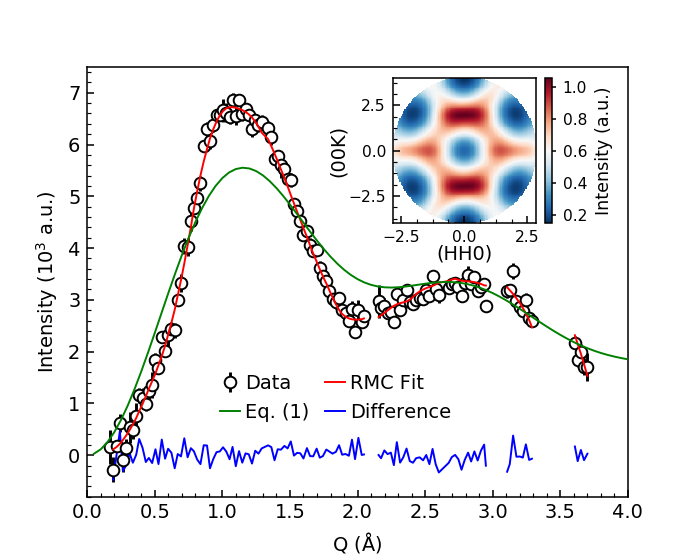

C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: invalid value encountered in divide


(201, 161)
5.0


In [6]:
# Ｃｏｍｂｉｎｅ　ｔｈｅ　ｔｗｏ　ｆｉｇｕｒｅｓ
#Ｐｌｏｔ　ｔｈｅ　ｄａｔａ　ａｎｄ　ｆｉｔｔｉｎｇ （binned data and with J2 in the form factor）
path='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/'
fname='tho_100mk-160k_binned_addPara4900_data.txt'

axfs = 10; tkfs=10; legfs= 10

# with paramagnetic intensity
dataf = np.genfromtxt(os.path.join(path,fname), dtype=None, skip_header=0,delimiter=None)
fname='tho_100mk-160k_binned_addPara4900_fit_*.txt'
fnames=[] #index for different files
for file in os.listdir(path):
    if fnmatch.fnmatch(file, fname):      
        print(file)
        fnames.append(file)
print fnames

# Plot
fig=plt.figure(figsize=(5,4))
plt.errorbar(dataf[:,0],dataf[:,1]/1000,dataf[:,2]/1000, color='black', fmt='o',markersize='6', mfc='white', label='Data')

r=3.7
plt.plot(q,5000*(1-np.sin(q*r)/(q*r))*tbformfact(q)/1000,zorder=4,color='green',lw=1.,label='Eq. (1)')
         #label=r'$f(Q)^2[1-\frac{\sin(Qr_\mathrm{nn})}{Qr_\mathrm{nn}}]$')

plt.xlabel(r"$\rm Q\ (\AA$)",size=axfs)
plt.ylabel('Intensity ($10^3$ a.u.)',size=axfs)
#from matplotlib import ticker
#plt.gca().yaxis.set_major_formatter()

#smooth the data and save for fitting with 0.5*error
for fname in [fnames[0]]:
    fit = np.genfromtxt(os.path.join(path,fname), dtype=None, skip_header=1,delimiter=None)
    fit[:,1] = fit[:,1]/1000
    fit_smooth = savgol_filter(fit[:,1], 21, 3) # window size 51, polynomial order 3
    diff = dataf[1:,1]/1000-fit[:,1]
    
    #plt.plot(fit[:,0],fit[:,1],'red', label='Fitting',zorder = 3) 
    m0, m1, m2, m3 = fit[:,0]<2.07, (2.125<fit[:,0])&(fit[:,0]<3.), (3.<fit[:,0])&(fit[:,0]<3.5), 3.5<fit[:,0]
    
    plt.plot(fit[m0,0],fit_smooth[m0],fit[m1,0],fit_smooth[m1],fit[m2,0],fit_smooth[m2],fit[m3,0],fit_smooth[m3],
             color='red',linewidth=1, label='RMC Fit',zorder = 3)
    plt.plot(fit[m0,0],diff[m0],fit[m1,0],diff[m1],fit[m2,0],diff[m2],fit[m3,0],diff[m3],
             color = 'blue', linewidth=1,label='Difference')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[9],handles[0],handles[4],handles[8]], [labels[9],labels[0],labels[4],labels[8]],ncol=2,columnspacing=0.8,
           numpoints=1,frameon=False,framealpha=1,fontsize=legfs,fancybox=True,shadow=False,handlelength=1,handletextpad=0.3,
           bbox_to_anchor=(0.46,0.23),
           bbox_transform=plt.gca().transAxes)

plt.minorticks_on()
plt.xticks(color='k', size=tkfs)
plt.yticks(color='k', size=tkfs)
plt.tick_params(axis='both',which='both',direction='in')
plt.xlim([0,4])
plt.ylim([-800/1000.,7500/1000.])

#######################################################################
############## Plot the color map as inset ############################
fpath='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/tho_100mk-160k_binned_addPara4900_sc.vtk'

reader = vtk.vtkDataSetReader()
reader.SetFileName(fpath)
reader.ReadAllScalarsOn()
reader.ReadAllVectorsOn()
reader.Update()

data = reader.GetOutput()
dim = data.GetDimensions()
print dim[:-1]

d = data.GetPointData()
array=d.GetArray('spin')
intensity = vtk_to_numpy(array).reshape(dim[:-1],order='F')

x = np.zeros(data.GetNumberOfPoints())
y = np.zeros(data.GetNumberOfPoints())

for i in range(data.GetNumberOfPoints()):
        x[i],y[i],_ = data.GetPoint(i) # coordinates x,y,z becuase z is the same, so discarded
print np.max(x)
x = x.reshape(dim[:-1],order='F')# this type of reshape!!!
y = y.reshape(dim[:-1],order='F')

import scipy as sp
import scipy.ndimage 
sigma_y = 8
sigma_x = 8
sigma = [sigma_y, sigma_x]
Z = sp.ndimage.filters.gaussian_filter(intensity, sigma, mode='constant')

# only plot Instrument largest Q range
Qlim = 4.
Qmod = np.sqrt(x**2+2*y**2)
Zm = np.ma.masked_where(Qmod > Qlim, Z)

ax = plt.axes([0.56, 0.6, .26, .26])
pcol = ax.pcolormesh(y, x, Zm/1500., cmap='RdBu_r',linewidth=0,rasterized=True)# '_r' is reversed colormap
pcol.set_edgecolor('face') # remove the white lines in the plot

ax.axis([ -Qlim/1.414, Qlim/1.414,-Qlim, Qlim])

plt.xlabel('(HH0)',size=10,labelpad=0)
plt.ylabel('(00K)',size=10,labelpad=0)

plt.minorticks_on()
plt.xticks(color='k', size=8)
plt.yticks(color='k', size=8)
plt.tick_params(direction='in',which='both')
ax.set_aspect(0.717)

# set colorbar and its properties
cb =plt.colorbar(pcol,pad=0.05)
cb.ax.set_ylabel('Intensity (a.u.)',fontsize=9)
cb.ax.tick_params(size=2,labelsize=8)

plt.show()

#fig.savefig(fpath.replace('vtk','eps'), bbox_inches="tight",verbose=True) 


In [104]:
# import seaborn as sns # After importing it, the default rc of matplotlib changes
# import matplotlib.pyplot as plt
# %matplotlib inline
# ax = sns.heatmap(intensity, square=True)#, cmap='RdBu_r')

(161, 161)
4.0


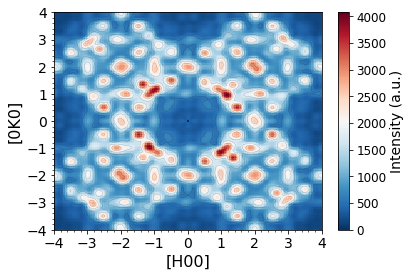

In [28]:
# ＰＬｏｔ　ｔｈｅ　ｓｉｍｕｌａｔｅｄ　ｓｉｎｇｌｅ　ｃｒｙｓｔａｌ　ｄｉｆｆｕｓｅ　ｓｃａｔｔｅｒｉｎｇ　ｐａｔｔｅｒｎ
# [HHK] plane

# load vtk and plot with Matplotlib
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util.numpy_support import vtk_to_numpy
% matplotlib inline

#fpath='D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact/tho_100mk-160k_binned_sc.vtk'
#fpath='D:\9_Program files\SpinVert\TbHfO_ND_Vivek/tho_100mk-160k_sc_hhl.vtk'
fpath='D:\9_Program files\SpinVert\TbHfO_ND_Vivek/tho_100mk-160k_sc_hh0.vtk'
fpath=r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara_sc_hh0.vtk'
reader = vtk.vtkDataSetReader()
reader.SetFileName(fpath)
reader.ReadAllScalarsOn()
reader.ReadAllVectorsOn()
reader.Update()

data = reader.GetOutput()
dim = data.GetDimensions()
print dim[:-1]

d = data.GetPointData()
array=d.GetArray('spin')
intensity = vtk_to_numpy(array).reshape(dim[:-1],order='F')
#array = reader.GetOutput().GetPointData().GetArray("my_scalar_name")# also work
#intensity = intensity[:-1,:-1]# x and y are bounds, so intensity should be the value *inside* those bounds.
# Therefore, remove the last value from the intensity array.

x = np.zeros(data.GetNumberOfPoints())
y = np.zeros(data.GetNumberOfPoints())

for i in range(data.GetNumberOfPoints()):
        x[i],y[i],_ = data.GetPoint(i) # coordinates x,y,z becuase z is the same, so discarded
print np.max(x)
x = x.reshape(dim[:-1],order='F')# this type of reshape!!!
y = y.reshape(dim[:-1],order='F')

# To get different color bars, reverse the plot order of conture and color plot
fig = plt.figure()
plt.contour(y, x, intensity, 6, colors='k',linewidths=0.1)  # negative contours will be dashed by default

# pcolormesh actually draws individual rectangles which contains white lines
pcol = plt.pcolormesh(y, x, intensity, cmap='RdBu_r',linewidth=0,rasterized=True)# '_r' is reversed colormap
pcol.set_edgecolor('face') # remove the white lines in the plot
#plt.imshow(intensity, interpolation='nearest', cmap='RdBu_r', extent=[y.min(), y.max(), x.min(), x.max()])
# imshow only for uniformly spaced point

#plt.title(r'Gd$_2$Zr$_2$O$_7$')

# set the limits of the plot to the limits of the data
plt.axis([x.min(), x.max(), y.min(), y.max()])
#plt.axis([x.min(), x.max(), y.min(), y.max()])

# plt.xlabel('[HH0]',size=14)
# plt.ylabel('[00K]',size=14)

plt.xlabel('[H00]',size=16)
plt.ylabel('[0K0]',size=16)

plt.minorticks_on()
plt.xticks( color='k', size=14)
plt.yticks( color='k', size=14)

# set colorbar and its properties
cb = plt.colorbar() # label='Intensity', ticks=range(0,100)
cb.ax.set_ylabel('Intensity (a.u.)',fontsize=14)
#import matplotlib.font_manager
#font = matplotlib.font_manager.FontProperties(size=14)
#cb.ax.yaxis.label.set_font_properties(font)
cb.ax.tick_params(labelsize=12)

plt.show()
#fig.savefig('D:/9_Program files/SpinVert/gdzro_ill/fullprof/scale_7p2k_hhk.pdf', bbox_inches="tight",verbose=True)

C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: divide by zero encountered in divide
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: divide by zero encountered in divide


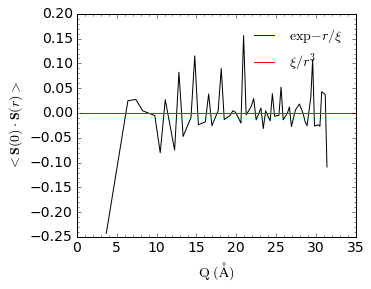

In [112]:
############### New
#Plot the Correlation functions
% matplotlib inline
fpath=r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_scf.txt'
fpath=r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara_scf.txt'
fpath=r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_addPara4900_scf.txt'
fpath=r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\large_superCell\tho_100mk-160k_binned_addPara4900_scf_server.txt'
fpath=r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\small_superCell\tho_100mk-160k_binned_addPara4900_scf.txt'

# The smooth data fitting
fpath = 'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact'
fpath = r'D:\9_Program files\SpinVert\TbHfO_ND_Vivek\with_J2_formfact\tho_100mk-160k_binned_8p2addP5300_30%accept/'
fname = 'tho_100mk-160k_binned_addPara4900_s_scf.txt'
fname = 'tho_100mk-160k_binned_8p2addP5300_scf.txt'
fpath = os.path.join(fpath,fname) 

data = np.genfromtxt(fpath, dtype=None, skip_header=0,delimiter=None)

from ipywidgets import interact,FloatSlider, RadioButtons
x=np.linspace(0.4,35,100)

amplitude_slider1 = FloatSlider(min=0, max=5, step=0.05, value=3)
amplitude_slider2 = FloatSlider(min=0, max=0.1, step=0.01, value=0.05)
@interact(r1=amplitude_slider1, r2=amplitude_slider2)
def pltc(r1,r2):
    fig, ax = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})
    ax.plot(data[:,0],data[:,1],color='black',linewidth=1)
    ax.plot(x,-np.exp(-x/r1),label=r'$\exp{-r/\xi}$')
    ax.plot(x,np.exp(-x/r1))
    ax.plot(x,r2/x**3,label=r'$\xi/r^3$')
    #ax.set_ylim(-0.4,0.4)

    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)
    
    plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
    plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
    plt.legend(frameon=False,framealpha=1,fontsize=14)
    
    plt.draw()

    #plt.title('New: The un-shifted data and fit')
    #fig.savefig('D:/9_Program files/SpinVert/gdzro_ill/fullprof/gd_not_shifted_correl.pdf', bbox_inches="tight",verbose=True)  